# Higgs Analysis:

>This notebook contains work performed on coffea-casa cloud server. 
> Work in progress

In [1]:
from datetime import datetime
import pytz

ist = pytz.timezone('Asia/Kolkata')

print(f"Last modified: {datetime.now(ist).strftime('%d %B %Y, %H:%M')} IST")


Last modified: 17 October 2025, 10:44 IST


# Imports 

In [2]:
import os
import sys
import time
import gc
import psutil

# Data processing
import uproot
import awkward as ak
import numpy as np

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Numerical computing
import vector
from hist import Hist
from tqdm import tqdm

# Parallel processing 
import dask
from dask import delayed, compute
from dask.distributed import Client, LocalCluster
import dask.bag as db
from dask.diagnostics import ProgressBar

# others
!pip install prettytable
from prettytable import PrettyTable

vector.register_awkward()

print(" All imports loaded")

  Using cached prettytable-3.16.0-py3-none-any.whl.metadata (33 kB)
Using cached prettytable-3.16.0-py3-none-any.whl (33 kB)
 All imports loaded


# Setting up directory and files

In [3]:

print(f"Server: {os.uname().nodename}")
# Parallel processing
N_WORKERS = 9       # One for each process

XROOTD_TIMEOUT = 600  # 10 minutes read timeout
XROOTD_MAX_RETRIES = 3  # Retry failed files 3 times
XROOTD_RETRY_WAIT = 10  # Wait 10 seconds between retries

print(f"Using {N_WORKERS} parallel workers")
print(f"XRootD timeout: {XROOTD_TIMEOUT}s ({XROOTD_TIMEOUT/60:.1f} min)")
print(f"Max retries: {XROOTD_MAX_RETRIES}")

# File paths
BASE_PATH = "/home/cms-jovyan/H-to-WW-NanoAOD-analysis/Datasets"
DATA_DIR = os.path.join(BASE_PATH, "DATA")
MC_DIR = os.path.join(BASE_PATH, "MC_samples")

# LOAD FILE URLS

def load_urls_from_file(filepath, max_files=None):
    """Load XRootD URLs from text file"""
    urls = []
    if not os.path.exists(filepath):
        return urls
    
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if line and line.startswith('root://'):
                urls.append(line)
                if max_files and len(urls) >= max_files:
                    break
    return urls

def load_all_files(data_dir, mc_dir, max_per_sample=None):
    """Load all file URLs from directories"""
    
    files_dict = {}
    
    
    mapping = {
        # Data 
        'data': 'Data',      
        # MC samples
        'higgs': 'signal',
        'dytoll': 'DY_to_Tau_Tau',      # DYtoLL.txt
        'top': 'Top_antitop',            # Top.txt
        'fakes': 'Fakes',                # Fakes.txt
        'vz': 'Diboson',                 # VZ.txt(Diboson)
        'ggww': 'ggWW',                  # ggWW.txt
        'ww': 'WW',                      # WW.txt 
        'vg': 'VG'                       # VG.txt
    }
    
    for directory in [data_dir, mc_dir]:
        if not os.path.exists(directory):
            continue
            
        for filename in os.listdir(directory):
            if not filename.endswith(('.txt')):
                continue
                
            filepath = os.path.join(directory, filename)
            filename_lower = filename.lower().replace('.txt', '')
            
            # Find label
            label = None
            for pattern, sample_label in mapping.items():
                if pattern in filename_lower:
                    label = sample_label
                    break
            
            if not label:
                print(f"   Unknown file: {filename} - skipping")
                continue
            
            # Load URLs
            urls = load_urls_from_file(filepath, max_per_sample)
            
            if urls:
                if label in files_dict:
                    files_dict[label].extend(urls)
                else:
                    files_dict[label] = urls
    
    return files_dict
    
# Load files (use max_per_sample=2 for testing, remove for full run)
files = load_all_files(DATA_DIR, MC_DIR, max_per_sample=5)  # TESTING
# files = load_all_files(DATA_DIR, MC_DIR)  # FULL ANALYSIS

print("\n" + "="*70)
print("FILES TO PROCESS")
print("="*70)
total = 0
for label, urls in files.items():
    print(f"{label:20s}: {len(urls):4d} files")
    total += len(urls)
print("_"*70)
print(f"{'TOTAL':20s}: {total:4d} files")
print("="*70)

Server: jupyter-anujraghav-2ephysics-40gmail-2ecom
Using 9 parallel workers
XRootD timeout: 600s (10.0 min)
Max retries: 3

FILES TO PROCESS
Data                :    5 files
VG                  :    5 files
signal              :    5 files
WW                  :    5 files
Fakes               :    5 files
Diboson             :    5 files
DY_to_Tau_Tau       :    5 files
ggWW                :    5 files
Top_antitop         :    5 files
______________________________________________________________________
TOTAL               :   45 files


In [4]:
SAMPLES = {
    "signal": {
        "color": "#EC2424",  # Red
        "is_signal": True,
        "stack_order": None
    },
    "DY_to_Tau_Tau": {
        "color": "#0C3AA5",  # Blue
        "is_signal": False,
        "stack_order": 0
    },
    "WW": {
        "color": "#DE809F",  # Pink
        "is_signal": False,
        "stack_order": 1
    },
    "ggWW": {
        "color": "#00BFFF",  # Dark pink
        "is_signal": False,
        "stack_order": 2
    },
    "Top_antitop": {
        "color": "#29B829",  # Green
        "is_signal": False,
        "stack_order": 3
    },
    "Diboson": {
        "color": "#DDB340",  # Yellow/Gold
        "is_signal": False,
        "stack_order": 4
    },
    "VG": {
        "color": "#B26EF1",  # Purple
        "is_signal": False,
        "stack_order": 5
    },
    "Fakes": {
        "color": "#808080",  # Gray
        "is_signal": False,
        "stack_order": 6
    },
    "Data": {
        "color": "#000000",  # Black
        "is_signal": False,
        "stack_order": None
    }
}

colors = {key: value["color"] for key, value in SAMPLES.items()}

## Loading branches to use 

In [5]:
def load_events(file_url, batch_size=50_000, timeout=600, max_retries=3, retry_wait=10):

    
    columns = [
        "Electron_pt", "Electron_eta", "Electron_phi", "Electron_mass", 
        "Electron_mvaFall17V2Iso_WP90", "Electron_charge",
        "Muon_pt", "Muon_eta", "Muon_phi", "Muon_mass", 
        "Muon_tightId", "Muon_charge", "Muon_pfRelIso04_all",
        "MET_pt", "MET_phi",
        "Jet_pt", "Jet_eta", "Jet_phi", "Jet_mass",
        "Jet_btagDeepFlavB", "nJet", "Jet_jetId", "Jet_puId",
    ]
    
    for attempt in range(max_retries):
        try:
            # Open file with timeout
            with uproot.open(file_url, timeout=timeout, num_workers=1) as f:
                tree = f['Events']
                
                # Iterate through batches
                for arrays in tree.iterate(columns, step_size=batch_size, library="ak"):
                    yield arrays
                
                # Success - exit retry loop
                return
                
        except (TimeoutError, OSError, IOError, ConnectionError) as e:
            error_type = type(e).__name__
            file_name = file_url.split('/')[-1]
            
            if attempt < max_retries - 1:
                print(f"      {error_type} on {file_name}")
                print(f"       Retry {attempt+1}/{max_retries-1} in {retry_wait}s...")
                time.sleep(retry_wait)
            else:
                print(f"     FAILED after {max_retries} attempts: {file_name}")
                print(f"       Error: {str(e)[:100]}")
                raise
                
        except Exception as e:
            # Unknown error - don't retry
            file_name = file_url.split('/')[-1]
            print(f"     Unexpected error on {file_name}: {str(e)[:100]}")
            raise

## Helper functions

In [6]:
# %%
def wrap_angle_to_pi(angle):
    """More concise way to wrap angle to [-π, π] range"""
    return (angle + np.pi) % (2 * np.pi) - np.pi

def create_lepton_vector(lepton):
    """Create 4-vector from lepton properties - unified function"""
    return vector.array({
        "pt": lepton.pt,
        "eta": lepton.eta,
        "phi": lepton.phi,
        "mass": lepton.mass
    })

## Selecting tight leptons (Electrons and Muon)

In [7]:

# %%
def select_tight_leptons(arrays):
    """Apply tight ID and isolation cuts to leptons"""
    # Define selection masks
    tight_electron_mask = arrays.Electron_mvaFall17V2Iso_WP90 == 1
    tight_muon_mask = (arrays.Muon_tightId == 1) & (arrays.Muon_pfRelIso04_all < 0.15)
    
    # Create structured arrays for selected leptons
    tight_electrons = ak.zip({
        "pt": arrays.Electron_pt[tight_electron_mask],
        "eta": arrays.Electron_eta[tight_electron_mask],
        "phi": arrays.Electron_phi[tight_electron_mask],
        "mass": arrays.Electron_mass[tight_electron_mask],
        "charge": arrays.Electron_charge[tight_electron_mask],
        "flavor": ak.ones_like(arrays.Electron_pt[tight_electron_mask]) * 11
    })
    
    tight_muons = ak.zip({
        "pt": arrays.Muon_pt[tight_muon_mask],
        "eta": arrays.Muon_eta[tight_muon_mask],
        "phi": arrays.Muon_phi[tight_muon_mask],
        "mass": arrays.Muon_mass[tight_muon_mask],
        "charge": arrays.Muon_charge[tight_muon_mask],
        "flavor": ak.ones_like(arrays.Muon_pt[tight_muon_mask]) * 13
    })
    
    # Combine into single collection
    tight_leptons = ak.concatenate([tight_electrons, tight_muons], axis=1)
    
    return tight_leptons, tight_electron_mask, tight_muon_mask

In [8]:
def select_e_mu_events(tight_leptons, met_arrays, leading_pt_cut=25, subleading_pt_cut=15):
    """Select events with exactly 1 electron and 1 muon"""
    
    # Sort by pT
    sorted_leptons = tight_leptons[ak.argsort(tight_leptons.pt, ascending=False)]
    
    # Require at least 2 leptons
    mask_2lep = ak.num(sorted_leptons) == 2
    events_2lep = sorted_leptons[mask_2lep]
    met_2lep = met_arrays[mask_2lep]
    
    if len(events_2lep) == 0:
        return None, None, {}, None
    
    # Get leading and subleading
    leading = events_2lep[:, 0]
    subleading = events_2lep[:, 1]
    
    # Selection criteria
    mask_1e1mu = ((leading.flavor == 11) & (subleading.flavor == 13)) | \
                 ((leading.flavor == 13) & (subleading.flavor == 11))
    mask_opposite_charge = leading.charge * subleading.charge < 0
    mask_pt = (leading.pt > leading_pt_cut) & (subleading.pt > subleading_pt_cut)
    
    # Final selection
    final_mask = mask_1e1mu & mask_opposite_charge & mask_pt
    
    # Store cutflow information
    cutflow = {
        'events_2lep': len(leading),
        'events_1e1mu': ak.sum(mask_1e1mu),
        'events_opposite_charge': ak.sum(mask_1e1mu & mask_opposite_charge),
        'events_final': ak.sum(final_mask)
    }
    
    return leading[final_mask], subleading[final_mask], cutflow, met_2lep[final_mask]


## Calculating  kinematic variables 
- Invariant mass of dilepton(electron and muon) system
- Transverse momentum of dilepton system
- Azimuathal seperation between dileptons
- Transverse mass of Higgs
- Transvers mass of subleading lepton and $E^T_{miss}$ 
  

In [9]:
def cal_kinematic_var(leading, subleading, met):

    lepton_1 = create_lepton_vector(leading)
    lepton_2 = create_lepton_vector(subleading)


    dilepton = lepton_1 + lepton_2

    masses = dilepton.mass
    ptll = dilepton.pt
    dphi = wrap_angle_to_pi(leading.phi - subleading.phi)


    mt_higgs_dphi = wrap_angle_to_pi(dilepton.phi - met.phi)
    mt_higgs = np.sqrt(2 * dilepton.pt * met.pt * (1 - np.cos(mt_higgs_dphi)))

    mt_l2_met_dphi = wrap_angle_to_pi(subleading.phi - met.phi)
    mt_l2_met = np.sqrt(2 * subleading.pt * met.pt * (1 - np.cos(mt_l2_met_dphi)))


    return masses, ptll, dphi, mt_higgs, mt_l2_met


## Calculating Invriant mass of jets and applying $m_{jj}$

In [10]:
def calculate_mjj(jets):
    """Calculate invariant mass of the two leading jets.
    
    Assumes jets are already sorted by pT (descending).
    Returns 0 for events with < 2 jets.
    """
    # Get number of jets per event
    n_jets = ak.num(jets)
    
    # Initialize mjj with zeros for all events
    mjj = ak.zeros_like(n_jets, dtype=float)
    
    # Create mask for events with at least 2 jets
    has_two_jets = n_jets >= 2
    
    # Only proceed if there are events with 2+ jets
    if ak.any(has_two_jets):
        # Use padding to safely access indices
        jets_padded = ak.pad_none(jets, 2, axis=1)
        
        # Create 4-vectors for jets
        jet_vectors = ak.zip({
            "pt": ak.fill_none(jets_padded.pt, 0.0),
            "eta": ak.fill_none(jets_padded.eta, 0.0),
            "phi": ak.fill_none(jets_padded.phi, 0.0),
            "mass": ak.fill_none(jets_padded.mass, 0.0)
        }, with_name="Momentum4D")
        
        # Get first two jets
        jet1 = jet_vectors[:, 0]
        jet2 = jet_vectors[:, 1]
        
        # Calculate invariant mass using vector addition
        dijet = jet1 + jet2
        mjj_calculated = dijet.mass
        
        # Apply only where we have 2+ jets
        mjj = ak.where(has_two_jets, mjj_calculated, 0.0)
    
    return mjj

def apply_mjj_window(mjj):
    return (mjj < 65) | ((mjj > 105) & (mjj < 120))

## 

## Counting jets and 0/1/2 Jet categorisation

In [11]:

def count_jets(arrays, jet_pt_threshold=30, tight_leptons = None):
   

    # Step 1: Create Jet object from individual arrays
    jets = ak.zip({
        "pt": arrays.Jet_pt,
        "eta": arrays.Jet_eta,
        "phi": arrays.Jet_phi,
        "mass": arrays.Jet_mass,
        "jetId": arrays.Jet_jetId,
        "btagDeepFlavB": arrays.Jet_btagDeepFlavB,
        "Jet_puId": arrays.Jet_puId
    })
    
    # Step 2: Good jet selection (Tight ID AND pt above threshold)
    pu_id_mask = (jets.pt > 50) | ((jets.pt <= 50) & (jets.Jet_puId >= 4))
    good_mask = (jets.jetId >= 2) & (abs(jets.phi)<4.7) & pu_id_mask
  
    if tight_leptons is None or ak.max(ak.num(tight_leptons)) == 0:
        return good_mask
    
    #  compute delta R between jets and leptons
    try:
        jets_eta = jets.eta[:, :, None]       
        jets_phi = jets.phi[:, :, None]
        leps_eta = tight_leptons.eta[:, None, :] 
        leps_phi = tight_leptons.phi[:, None, :]
        
        deta = jets_eta - leps_eta
        dphi = (jets_phi - leps_phi + np.pi) % (2*np.pi) - np.pi
        dr = np.sqrt(deta**2 + dphi**2)
        
        # Minimum delta R over all leptons for each jet
        min_dr = ak.min(dr, axis=-1)
        
        # Jets passing the delta R cut
        dr_cut_mask = min_dr > 0.4
        
        # Update good_mask
        good_mask = good_mask & dr_cut_mask
    
    except Exception as e:
        print(f"Warning: Lepton cleaning failed ({e}), skipping...")

    good_jets = jets[good_mask]
    
    # Step 3: Sort by pt
    order = ak.argsort(good_jets.pt, axis=1, ascending=False)
    sorted_jets = good_jets[order]

    lead_jet_pt = ak.fill_none(ak.firsts(sorted_jets.pt),0)
    sublead_jet_pt = ak.fill_none(ak.firsts(sorted_jets.pt[..., 1:]), 0)

    # Step 4: Calculate mjj
    mjj = calculate_mjj(sorted_jets)

    # Step 5: Category masks based on jet count  
    isZeroJet = (lead_jet_pt < jet_pt_threshold)
    isOneJet = (lead_jet_pt >= jet_pt_threshold) & (sublead_jet_pt < jet_pt_threshold)
    isTwoJet = (sublead_jet_pt >= jet_pt_threshold) & apply_mjj_window(mjj)

    n_jets = ak.sum(sorted_jets.pt >= jet_pt_threshold, axis = 1)

    return n_jets, good_mask, sorted_jets, isZeroJet, isOneJet, isTwoJet
    

In [12]:
def get_bjet_categories(arrays, btag_threshold=0.2217, eta_max=2.5):
    """
    Get different b-jet categories needed for SR/CR selection.
    """
    # Base b-jet selection 
    base_bjet_mask = (
        (arrays.Jet_jetId >= 2) &
        (abs(arrays.Jet_eta) < eta_max) &
        (arrays.Jet_btagDeepFlavB > btag_threshold)
    )
    
    # Different pT categories
    bjets_20 = base_bjet_mask & (arrays.Jet_pt > 20)
    bjets_20_30 = base_bjet_mask & (arrays.Jet_pt > 20) & (arrays.Jet_pt <= 30)
    bjets_30 = base_bjet_mask & (arrays.Jet_pt > 30)
    
    # Count per event
    n_bjets_20 = ak.sum(bjets_20, axis=1)
    n_bjets_20_30 = ak.sum(bjets_20_30, axis=1) 
    n_bjets_30 = ak.sum(bjets_30, axis=1)
    
    return {
        # For Signal Regions 
        'passes_bjet_veto': n_bjets_20 == 0,  
        
        # For Control Regions
        'has_btag_20_30': n_bjets_20_30 > 0,  # Top CR 0-jet
        'has_btag_30': n_bjets_30 > 0,        # Top CR 1-jet, 2-jet
        
        # Counts (for debugging/monitoring)
        'n_bjets_20': n_bjets_20,
        'n_bjets_20_30': n_bjets_20_30,
        'n_bjets_30': n_bjets_30
    }


def apply_bjet_selections(arrays):
   
    bjet_info = get_bjet_categories(arrays)
    
    # For Signal Regions - use like your original function
    sr_bjet_veto = bjet_info['passes_bjet_veto']
    
    # For Control Regions
    cr_top_0jet = bjet_info['has_btag_20_30']
    cr_top_1jet_2jet = bjet_info['has_btag_30']
    
    return sr_bjet_veto, bjet_info

## Defining Signal & Control region

In [13]:
def apply_signal_region_cuts(leading, subleading, met, masses, ptlls, mt_higgs, 
                           mt_l2_met, isZeroJet, isOneJet, isTwoJet, 
                           bjet_veto_mask, mjj=None):
    """Apply Signal Region selections for all jet categories."""
    
    # Base global selection for Signal Regions
    sr_base = (
        (leading.pt > 25) & 
        (subleading.pt > 15) &  
        (met.pt > 20) &
        (ptlls > 30) &
        (masses > 12) &
        (mt_l2_met > 30) &
        (subleading.pt <= 20) &  
        (mt_higgs > 60) &        # SR mt_higgs cut
        bjet_veto_mask           # No b-jets for SR
    )
    
    # Apply mjj window for 2-jet category
    if mjj is not None:
        mjj_window = apply_mjj_window(mjj)
    else:
        mjj_window = ak.ones_like(isTwoJet, dtype=bool)
    
    sr_regions = {
        'SR_0jet': sr_base & isZeroJet,
        'SR_1jet': sr_base & isOneJet,
        'SR_2jet': sr_base & isTwoJet & mjj_window
    }
    
    return sr_regions


In [14]:
def apply_control_region_cuts(leading, subleading, met, masses, ptlls, mt_higgs, 
                            mt_l2_met, isZeroJet, isOneJet, isTwoJet, 
                            bjet_info, mjj=None):
    """Apply Control Region selections for all jet categories."""
    
    # Base global selection for Control Regions (without mt_higgs and b-jet requirements)
    cr_base = (
        (leading.pt > 25) & 
        (subleading.pt > 15) &
        (met.pt > 20) &
        (ptlls > 30) &
        (masses > 12) &
        (mt_l2_met > 30) &
        (subleading.pt <= 20)
    )
    
    # Apply mjj window for 2-jet category
    if mjj is not None:
        mjj_window = apply_mjj_window(mjj)
    else:
        mjj_window = ak.ones_like(isTwoJet, dtype=bool)
    
    cr_regions = {}
    
    # === TOP CONTROL REGIONS ===
    cr_top_base = cr_base & (masses > 50)
    
    cr_regions['CR_top_0jet'] = (
        cr_top_base & 
        isZeroJet & 
        bjet_info['has_btag_20_30']  # 20 < pT < 30 GeV b-jets for 0-jet
    )
    
    cr_regions['CR_top_1jet'] = (
        cr_top_base & 
        isOneJet & 
        bjet_info['has_btag_30']     # pT > 30 GeV b-jets for 1-jet
    )
    
    cr_regions['CR_top_2jet'] = (
        cr_top_base & 
        isTwoJet & 
        mjj_window &
        bjet_info['has_btag_30']     # pT > 30 GeV b-jets for 2-jet
    )
    
    # === TAU-TAU CONTROL REGIONS ===
    cr_tau_base = (
        cr_base & 
        (mt_higgs < 60) & 
        (masses > 40) & 
        (masses < 80) &
        bjet_info['passes_bjet_veto']  # No b-jets for ττ CR
    )
    
    cr_regions['CR_tau_0jet'] = cr_tau_base & isZeroJet
    cr_regions['CR_tau_1jet'] = cr_tau_base & isOneJet  
    cr_regions['CR_tau_2jet'] = cr_tau_base & isTwoJet & mjj_window
    
    return cr_regions

## Global cuts 

In [15]:
def apply_global_cuts(leading, subleading, met, mt_higgs, mt_l2_met,ptlls,masses):
    """Apply global selection cuts"""
    # Global cuts
    mask_subleading_pt = subleading.pt >= 15 
    mask_mt_higgs = mt_higgs > 60
    mask_mt_l2_met = mt_l2_met > 30
    mask_met_pt = met.pt > 20
    mask_ptll  = ptlls > 30
    mask_mll = masses > 12 
    
    # Combine all masks
    global_mask = mask_mt_higgs & mask_mt_l2_met & mask_subleading_pt & mask_met_pt & mask_ptll & mask_mll

    return global_mask, {
        'pass_mt_higgs': ak.sum(mask_mt_higgs),
        'pass_mt_l2_met': ak.sum(mask_mt_l2_met),
        'pass_subleading_pt': ak.sum(mask_subleading_pt),
        'pass_met_pt': ak.sum(mask_met_pt),
        'pass_ptll': ak.sum(mask_ptll),
        'pass_mll': ak.sum(mask_mll),
        'pass_global': ak.sum(global_mask)
    }

In [16]:
def initialize_stage_storage():
    """Initialize storage for all selection stages including SR/CR"""
    return {
        # Original stages
        'before_cuts': {},
        'global': {},
        '0jet': {},
        '1jet': {},
        '2jet': {},
        
        # Signal Regions
        'SR_0jet': {},
        'SR_1jet': {},
        'SR_2jet': {},
        
        # Control Regions  
        'CR_top_0jet': {},
        'CR_top_1jet': {},
        'CR_top_2jet': {},
        'CR_tau_0jet': {},
        'CR_tau_1jet': {},
        'CR_tau_2jet': {}
    }

hist_data = {}
selected_leptons = {}
event_variables = {}

# Define binning
mass_bins = np.linspace(0, 200, 25)
met_bins = np.linspace(0, 200, 25)
dphi_bins = np.linspace(0, np.pi, 25)
ptll_bins = np.linspace(0, 200, 25)


stage_data = {}
for label in files.keys():
    stage_data[label] = initialize_stage_storage()


## Processing function

In [17]:
def Processing_files(label, file_urls, position):
    """Process all files with memory monitoring and progress tracking"""
    try:
        # Monitor memory
        process = psutil.Process(os.getpid())
        start_mem = process.memory_info().rss / (1024**3)
        start_time_sample = time.time()
        
        print(f"[Worker {position}] Starting: {label} ({len(file_urls)} files) - RAM: {start_mem:.1f}GB")
        
        # Initialize collectors
        stage_collectors = {stage: {key: [] for key in 
                            ["mass", "met", "dphi", "ptll",
                             "mt_higgs", "mt_l2_met", "mjj",
                             "leading", "subleading"]} 
                    for stage in ['before_cuts', 'global', '0jet', '1jet', '2jet',
                                  'SR_0jet', 'SR_1jet', 'SR_2jet',
                                  'CR_top_0jet', 'CR_top_1jet', 'CR_top_2jet',
                                  'CR_tau_0jet', 'CR_tau_1jet', 'CR_tau_2jet']}
        
        cutflow = {stage: 0 for stage in ['total', 'e_mu_preselection', 'global_cuts'] + 
                   ['0jet', '1jet', '2jet'] +
                   ['SR_0jet', 'SR_1jet', 'SR_2jet'] +
                   ['CR_top_0jet', 'CR_top_1jet', 'CR_top_2jet'] +
                   ['CR_tau_0jet', 'CR_tau_1jet', 'CR_tau_2jet']}
        
        # Process each file
        for file_idx, file_url in enumerate(file_urls):
            file_name = file_url.split('/')[-1]
            
            # Progress reporting every 5 files
            if file_idx % 5 == 0 or file_idx == len(file_urls) - 1:
                current_mem = process.memory_info().rss / (1024**3)
                mem_delta = current_mem - start_mem
                elapsed = time.time() - start_time_sample
                print(f"[Worker {position}] {label}: File {file_idx+1}/{len(file_urls)} "
                      f"- RAM: {current_mem:.1f}GB (+{mem_delta:.1f}GB) - {elapsed/60:.1f}min")
            
            try:
               
                for arrays in load_events(
                    file_url,
                    batch_size=50_000,
                    timeout=XROOTD_TIMEOUT,
                    max_retries=XROOTD_MAX_RETRIES,
                    retry_wait=XROOTD_RETRY_WAIT
                ):
                    cutflow['total'] += len(arrays)
                    
                    # Get tight leptons
                    tight_leptons, _, _ = select_tight_leptons(arrays)
                    met = ak.zip({"pt": arrays.MET_pt, "phi": arrays.MET_phi})
                    
                    # Apply e-mu selection
                    leading, subleading, emu_cutflow, met_selected = select_e_mu_events(tight_leptons, met)
                    
                    if leading is None or len(leading) == 0:
                        continue
                        
                    cutflow['e_mu_preselection'] += len(leading)
                    
                    # Calculate kinematic variables
                    masses, ptlls, dphis, mt_higgs, mt_l2_met = cal_kinematic_var(leading, subleading, met_selected)
                    
                    mjj_before = ak.zeros_like(masses)
                    for key, value in zip(stage_collectors['before_cuts'].keys(),
                                          [masses, met_selected.pt, dphis, ptlls, mt_higgs, mt_l2_met, mjj_before, leading, subleading]):
                        stage_collectors['before_cuts'][key].append(value)
                    
                    # Global cuts and jet counting
                    sorted_leptons = tight_leptons[ak.argsort(tight_leptons.pt, ascending=False)]
                    has_2lep = ak.num(sorted_leptons) == 2
                    
                    events_2lep = sorted_leptons[has_2lep]
                    if len(events_2lep) > 0:
                        lead_all = events_2lep[:, 0]
                        sublead_all = events_2lep[:, 1]
                        
                        mask_1e1mu = ((lead_all.flavor == 11) & (sublead_all.flavor == 13)) | \
                                     ((lead_all.flavor == 13) & (sublead_all.flavor == 11))
                        mask_charge = lead_all.charge * sublead_all.charge < 0
                        mask_pt = (lead_all.pt > 25) & (sublead_all.pt > 15)
                        
                        emu_mask_2lep = mask_1e1mu & mask_charge & mask_pt
                        
                        indices_2lep = ak.where(has_2lep)[0]
                        indices_emu = indices_2lep[emu_mask_2lep]

                        n_jets_full, _, sorted_jets_full, isZeroJet_full, isOneJet_full, isTwoJet_full = count_jets(
                            arrays, tight_leptons=tight_leptons
                        )
                        mjj_full = calculate_mjj(sorted_jets_full)
                        mjj_selected = mjj_full[indices_emu]
                        mjj_selected = ak.fill_none(mjj_selected, np.nan)
                        
                        global_cut_mask, _ = apply_global_cuts(leading, subleading, met_selected, mt_higgs, mt_l2_met, ptlls, masses)
                        bjet_veto_full, bjet_info_full = apply_bjet_selections(arrays)
                        bjet_veto_selected = bjet_veto_full[indices_emu]
                        bjet_info_selected = {key: value[indices_emu] for key, value in bjet_info_full.items()}
                        
                        global_mask_selected = global_cut_mask & bjet_veto_selected
                        cutflow['global_cuts'] += ak.sum(global_mask_selected)
                        
                        if ak.sum(global_mask_selected) > 0:
                            for key, value in zip(stage_collectors['global'].keys(),
                                                 [masses, met_selected.pt, dphis, ptlls, mt_higgs, mt_l2_met, mjj_selected, leading, subleading]):
                                stage_collectors['global'][key].append(value[global_mask_selected])
                            
                            isZeroJet_selected = isZeroJet_full[indices_emu]
                            isOneJet_selected = isOneJet_full[indices_emu]
                            isTwoJet_selected = isTwoJet_full[indices_emu]

                            mask_0jet = global_mask_selected & isZeroJet_selected
                            mask_1jet = global_mask_selected & isOneJet_selected
                            mask_2jet = global_mask_selected & isTwoJet_selected

                            cutflow['0jet'] += ak.sum(mask_0jet)
                            cutflow['1jet'] += ak.sum(mask_1jet)
                            cutflow['2jet'] += ak.sum(mask_2jet)

                            for stage_name, mask in [('0jet', mask_0jet), ('1jet', mask_1jet), ('2jet', mask_2jet)]:
                                if ak.sum(mask) > 0:
                                    for key, value in zip(stage_collectors[stage_name].keys(),
                                                         [masses, met_selected.pt, dphis, ptlls, mt_higgs, mt_l2_met, mjj_selected, leading, subleading]):
                                        stage_collectors[stage_name][key].append(value[mask])
                            
                            # Signal and Control Regions
                            sr_regions = apply_signal_region_cuts(
                                leading, subleading, met_selected, masses, ptlls, mt_higgs,
                                mt_l2_met, isZeroJet_selected, isOneJet_selected, isTwoJet_selected,
                                bjet_veto_selected, mjj_selected
                            )
                            
                            cr_regions = apply_control_region_cuts(
                                leading, subleading, met_selected, masses, ptlls, mt_higgs,
                                mt_l2_met, isZeroJet_selected, isOneJet_selected, isTwoJet_selected,
                                bjet_info_selected, mjj_selected
                            )
                            
                            all_regions = {**sr_regions, **cr_regions}
                            
                            for region_name, region_mask in all_regions.items():
                                cutflow[region_name] += ak.sum(region_mask)
                                if ak.sum(region_mask) > 0:
                                    for key, value in zip(stage_collectors[region_name].keys(),
                                                         [masses, met_selected.pt, dphis, ptlls, mt_higgs, mt_l2_met, mjj_selected, leading, subleading]):
                                        stage_collectors[region_name][key].append(value[region_mask])
                    
                    # Clear memory after batch
                    del arrays
                    gc.collect()
                
            except Exception as e:
                print(f"[Worker {position}]  Skipping {file_name}: {str(e)[:80]}")
                continue  # Skip this file, continue with next
            
             # garbage collection after each file
            gc.collect()
        
        # Concatenate results
        stage_data = {}
        for stage in stage_collectors.keys():
            stage_data[stage] = {}
            for key in stage_collectors[stage].keys():
                if stage_collectors[stage][key]:
                    stage_data[stage][key] = ak.concatenate(stage_collectors[stage][key])
                else:
                    stage_data[stage][key] = ak.Array([])
        
        # Final stats
        end_mem = process.memory_info().rss / (1024**3)
        elapsed = time.time() - start_time_sample
        print(f"[Worker {position}] {label} completed ({cutflow['total']:,} events) "
              f"- RAM: {end_mem:.1f}GB - Time: {elapsed/60:.1f}min")
        
        return label, stage_data, cutflow, None
        
    except Exception as e:
        import traceback
        error_msg = traceback.format_exc()
        return label, None, None, error_msg

## Main processing loop using Dask

In [18]:


# MAIN PROCESSING 

print("\n" + "="*70)
print("PROCESSING START")
print("="*70)
print(f"Workers: {N_WORKERS} | Samples: {len(files)} | Files: {sum(len(urls) for urls in files.values())}")
print("="*70)

stage_data_final = {}
start_time = time.time()


delayed_tasks = []
for pos, (label, urls) in enumerate(files.items()):
    task = delayed(Processing_files)(label, urls, pos)
    delayed_tasks.append((label, task))

print(f"\nProcessing {len(delayed_tasks)} samples in parallel...\n")

#  progress bar
with ProgressBar():
    with dask.config.set(scheduler='threads', num_workers=N_WORKERS):
        results = dask.compute(*[task for _, task in delayed_tasks])

print() 

# Collect results
for (label, _), result in zip(delayed_tasks, results):
    ret_label, stage_data, cutflow, error = result
    
    if error:
        print(f"{label:20s} - ERROR")
        stage_data_final[label] = {stage: {key: ak.Array([]) for key in 
            ["mass", "met", "dphi", "ptll", "mt_higgs", "mt_l2_met", "mjj", "leading", "subleading"]}
            for stage in ['before_cuts', 'global', '0jet', '1jet', '2jet',
                          'SR_0jet', 'SR_1jet', 'SR_2jet',
                          'CR_top_0jet', 'CR_top_1jet', 'CR_top_2jet',
                          'CR_tau_0jet', 'CR_tau_1jet', 'CR_tau_2jet']}
    else:
        stage_data_final[label] = stage_data
        if cutflow:
            print(f" {label:20s} {cutflow['total']:>10,} events")

total_time = time.time() - start_time

print("\n" + "="*70)
print(f"COMPLETE - Time: {total_time:.1f}s ({total_time/60:.1f} min)")
print("="*70 + "\n")


PROCESSING START
Workers: 9 | Samples: 9 | Files: 45

Processing 9 samples in parallel...

[                                        ] | 0% Completed | 276.29 us[Worker 7] Starting: ggWW (5 files) - RAM: 0.2GB
[Worker 5] Starting: Diboson (5 files) - RAM: 0.2GB
[Worker 8] Starting: Top_antitop (5 files) - RAM: 0.2GB
[Worker 5] Diboson: File 1/5 - RAM: 0.2GB (+0.0GB) - 0.0min
[Worker 7] ggWW: File 1/5 - RAM: 0.2GB (+0.0GB) - 0.0min
[Worker 8] Top_antitop: File 1/5 - RAM: 0.2GB (+0.0GB) - 0.0min
[Worker 4] Starting: Fakes (5 files) - RAM: 0.2GB
[Worker 4] Fakes: File 1/5 - RAM: 0.2GB (+0.0GB) - 0.0min
[Worker 2] Starting: signal (5 files) - RAM: 0.2GB
[Worker 3] Starting: WW (5 files) - RAM: 0.2GB
[Worker 2] signal: File 1/5 - RAM: 0.2GB (+0.0GB) - 0.0min
[Worker 3] WW: File 1/5 - RAM: 0.2GB (+0.0GB) - 0.0min
[Worker 1] Starting: VG (5 files) - RAM: 0.2GB
[Worker 6] Starting: DY_to_Tau_Tau (5 files) - RAM: 0.2GB
[Worker 1] VG: File 1/5 - RAM: 0.2GB (+0.0GB) - 0.0min
[Worker 6] DY_to_Tau_

## print

In [19]:
def print_cutflow(stage_data_final, samples):
    
    
   
    stage_info = [
        ('Before cuts', 'before_cuts'),
        ('Global', 'global'),
        ('0-jet', '0jet'),
        ('1-jet', '1jet'),
        ('2-jet', '2jet'),
        ('SR 0j', 'SR_0jet'),
        ('SR 1j', 'SR_1jet'),
        ('SR 2j', 'SR_2jet'),
        ('CR Top 0j', 'CR_top_0jet'),
        ('CR Top 1j', 'CR_top_1jet'),
        ('CR Top 2j', 'CR_top_2jet'),
        ('CR ττ 0j', 'CR_tau_0jet'),
        ('CR ττ 1j', 'CR_tau_1jet'),
        ('CR ττ 2j', 'CR_tau_2jet')
    ]
    

    order = [
        # Data
        'Data',       
        # Signal
        'signal',
        # Major backgrounds 
        'WW',
        'ggWW',
        'DY_to_Tau_Tau',
        'Top_antitop',
        'Diboson',
        'VG',
        # Data-driven
        'Fakes'
    ]
        

    sorted_samples = []
    for sample in order:
        if sample in samples:
            sorted_samples.append(sample)
    
    # 
    for sample in samples:
        if sample not in sorted_samples:
            sorted_samples.append(sample)
    
    # Create table with stages as columns
    table = PrettyTable()
    stage_names = [stage[0] for stage in stage_info]
    table.field_names = ['Process'] + stage_names
    
    # Set column alignment
    table.align['Process'] = 'l'
    for stage_name in stage_names:
        table.align[stage_name] = 'r'
    
    # Add rows for each sample in sorted order
    for sample in sorted_samples:
        row = [sample]
        
        if sample in stage_data_final and stage_data_final[sample]:
            data = stage_data_final[sample]
            
            for stage_name, stage_key in stage_info:
                if stage_key in data and data[stage_key] and 'mass' in data[stage_key]:
                    count = len(data[stage_key]['mass'])
                    row.append(f"{count:,}")
                else:
                    row.append("0")
        else:
            row.extend(["0"] * len(stage_info))
        
        table.add_row(row)
    
    # Add separator and total row
    if len(sorted_samples) > 1:
        table.add_row(['-'*10] + ['-'*10]*len(stage_names))
        
        total_row = ['TOTAL']
        for stage_name, stage_key in stage_info:
            total_count = 0
            for sample in sorted_samples:
                if sample in stage_data_final and stage_data_final[sample]:
                    data = stage_data_final[sample]
                    if stage_key in data and data[stage_key] and 'mass' in data[stage_key]:
                        total_count += len(data[stage_key]['mass'])
            total_row.append(f"{total_count:,}")
        table.add_row(total_row)
    
    print("\n" + "="*140)
    print(" CUTFLOW: PROCESSES vs SELECTION STAGES")
    print("="*140)
    print(table)
    print("="*140 + "\n")


print_cutflow(stage_data_final, list(files.keys()))


 CUTFLOW: PROCESSES vs SELECTION STAGES
+---------------+-------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
| Process       | Before cuts |     Global |      0-jet |      1-jet |      2-jet |      SR 0j |      SR 1j |      SR 2j |  CR Top 0j |  CR Top 1j |  CR Top 2j |   CR ττ 0j |   CR ττ 1j |   CR ττ 2j |
+---------------+-------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
| Data          |      35,944 |      3,121 |      1,265 |        915 |        134 |        228 |        139 |         12 |         66 |        190 |         75 |         26 |         47 |          7 |
| signal        |      17,654 |      8,950 |      5,748 |      2,337 |        137 |      1,812 |        523 |         22 |         78 |          6 |       

## Superimposed plots

In [20]:
def plot_stage_comparison(variable, var_props, stage_data_all):
    """Create comparison plot across selection stages for a given variable"""
    
    stages = ['before_cuts', 'global', '0jet', '1jet', '2jet']
    stage_labels = ['Before cuts', 'Global cuts', '0-jet', '1-jet', '≥2-jet']
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    
    for idx, (stage, stage_label) in enumerate(zip(stages, stage_labels)):
        ax = axes[idx]
        
        # Plot each sample
        for sample in files.keys():
            if sample in stage_data_all and stage_data_all[sample][stage] is not None:
                if variable in stage_data_all[sample][stage]:
                    data = ak.to_numpy(stage_data_all[sample][stage][variable])
                    
                    # if len(data) > 0:
                    #     ax.hist(data, bins=var_props['bins'], 
                    #            histtype='step', linewidth=2 if SAMPLES[sample]["is_signal"] else 1.5,
                    #            label=sample, color=SAMPLES[sample]["color"], alpha=0.8, density=True)
                        
                    #     hist, edges = np.histogram(data, bins=var_props['bins'], density=True)                        
                    #     centers = 0.5 * (edges[:-1] + edges[1:])
                    #     # errors = np.sqrt(hist / len(data))  # simple Poisson uncertainty
                    #     ax.errorbar(centers, hist, fmt='o', color=SAMPLES[sample]["color"], markersize=4, capsize=2, lw=1)
                    if len(data) > 0:
                        if "DATA" in sample.upper():
                            # Data → points with error bars
                            hist, edges = np.histogram(data, bins=var_props['bins'], density=True)
                            centers = 0.5 * (edges[:-1] + edges[1:])
                            # errors = np.sqrt(hist / len(data))  # Poisson error approximation
                            ax.errorbar(centers, hist, fmt='o', 
                                        color='black', markersize=4, capsize=2, lw=1,
                                        label=sample)
                        else:
                            # MC → standard step histogram
                            ax.hist(data, bins=var_props['bins'], histtype='step',
                                    linewidth=1.5 if SAMPLES[sample]["is_signal"] else 1,
                                    label=sample, color=SAMPLES[sample]["color"],
                                    alpha=0.8, density=True)

        
        ax.set_xlabel(var_props['xlabel'], fontsize=10)
        ax.set_title(stage_label, fontsize=11, fontweight='bold')
        ax.set_xlim(var_props['xlim'])
        
        ax.legend(fontsize=8)
        if idx == 0:
            ax.set_ylabel('Random Units', fontsize=10)
        
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'{variable.upper()} Distribution Across Selection Stages', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

In [21]:
#  comparison plots for each sample and variable
variables_to_plot = {
    'mass': {'bins': np.linspace(0, 200, 30), 'xlabel': '$m_{e\\mu}$ [GeV]', 'xlim': (0, 200)},
    'met': {'bins': np.linspace(0, 200, 30), 'xlabel': '$E_T^{miss}$ [GeV]', 'xlim': (0, 200)},
    'dphi': {'bins': np.linspace(0, np.pi, 30), 'xlabel': '$\\Delta\\phi_{e\\mu}$ [rad]', 'xlim': (0, np.pi)},
    'ptll': {'bins': np.linspace(0, 200, 30), 'xlabel': '$p_T^{e\\mu}$ [GeV]', 'xlim': (0, 200)},
    'mt_higgs': {'bins': np.linspace(0, 250, 30), 'xlabel': '$m_T^{H}$ [GeV]', 'xlim': (0, 250)},
    'mt_l2_met': {'bins': np.linspace(0, 200, 30), 'xlabel': '$m_T(\\ell_2, E_T^{miss})$ [GeV]', 'xlim': (0, 200)},
    'mjj': {'bins': np.linspace(0, 300, 30), 'xlabel': '$m_{jj}$ [GeV]', 'xlim': (0, 300)}

}


Creating comparison plots...

Plotting mass...


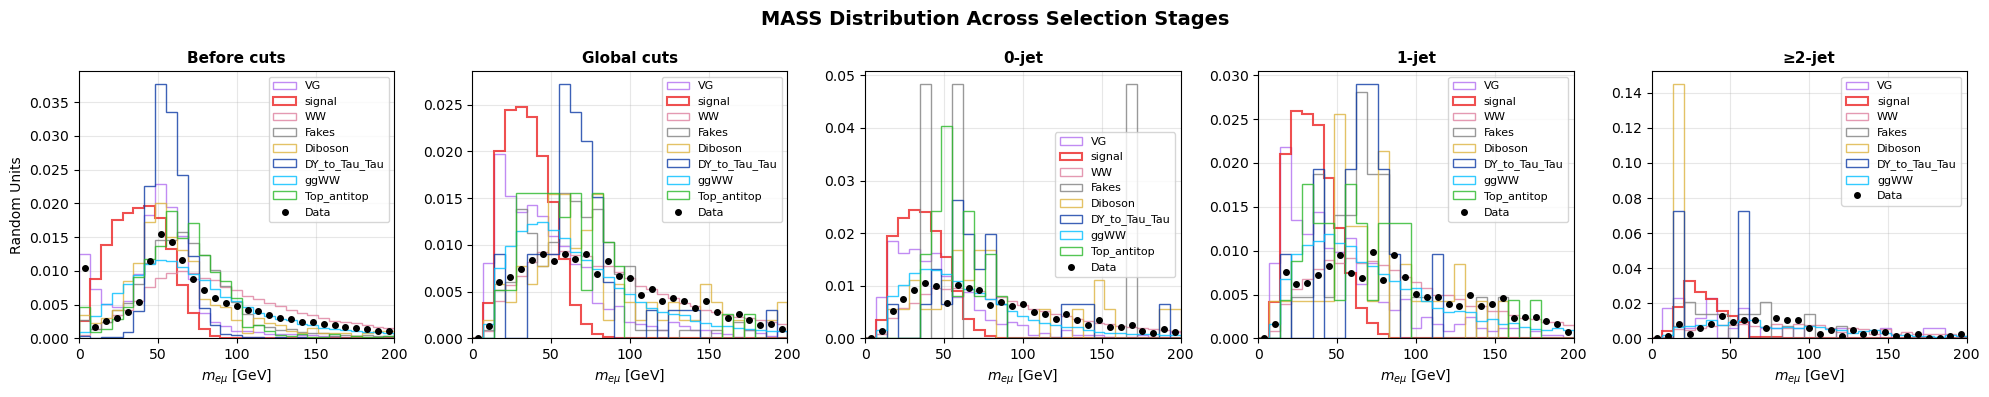


Plotting met...


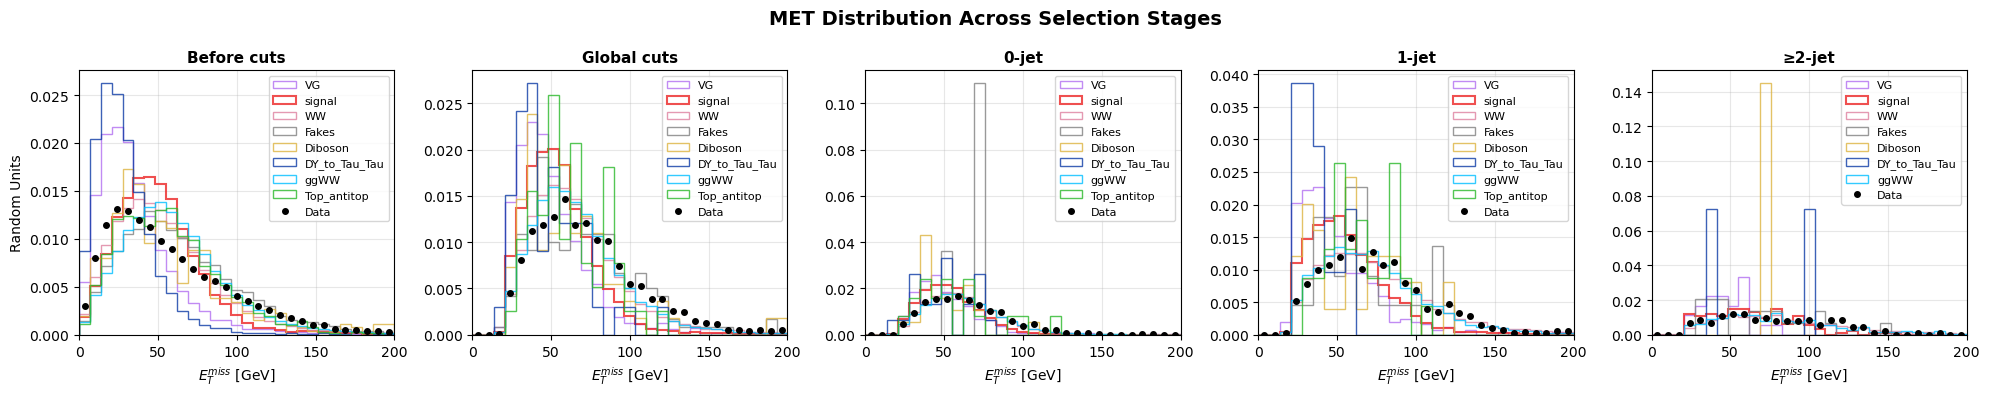


Plotting dphi...


/usr/local/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


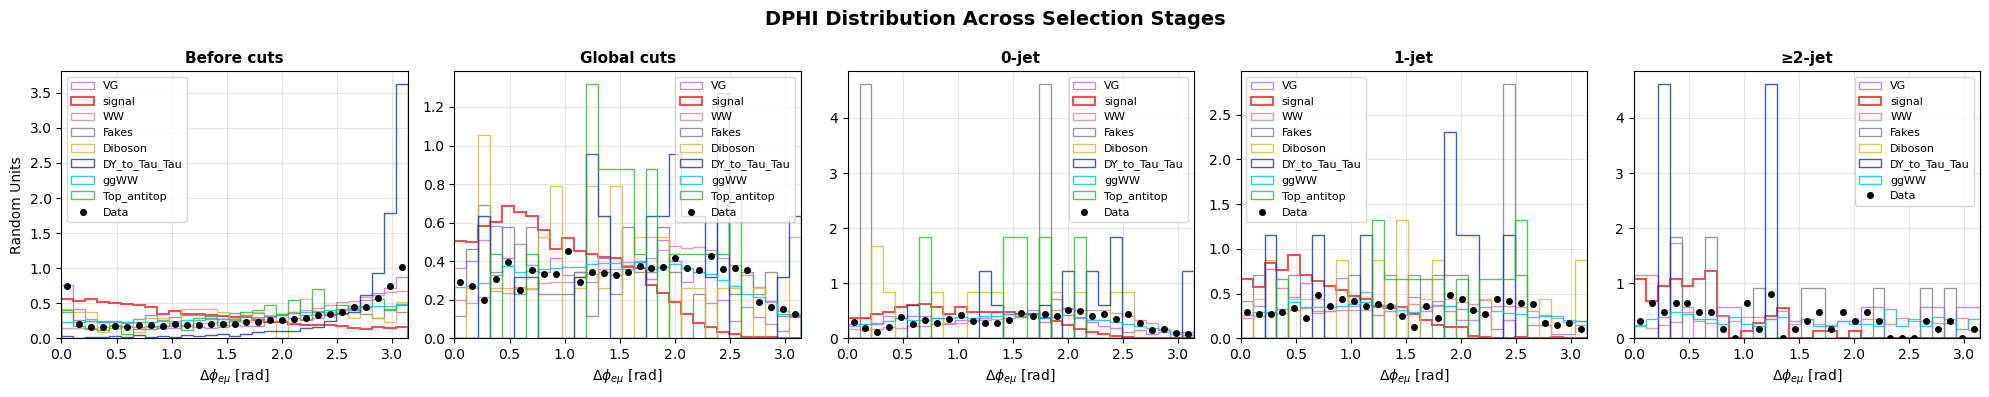


Plotting ptll...


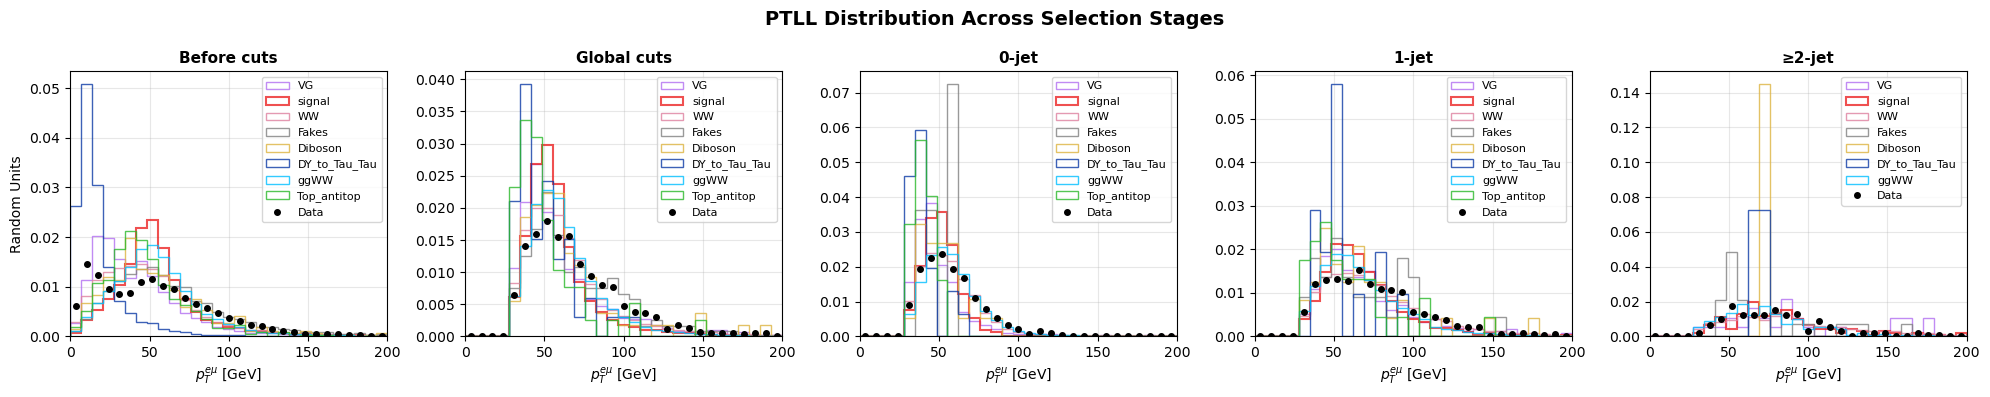


Plotting mt_higgs...


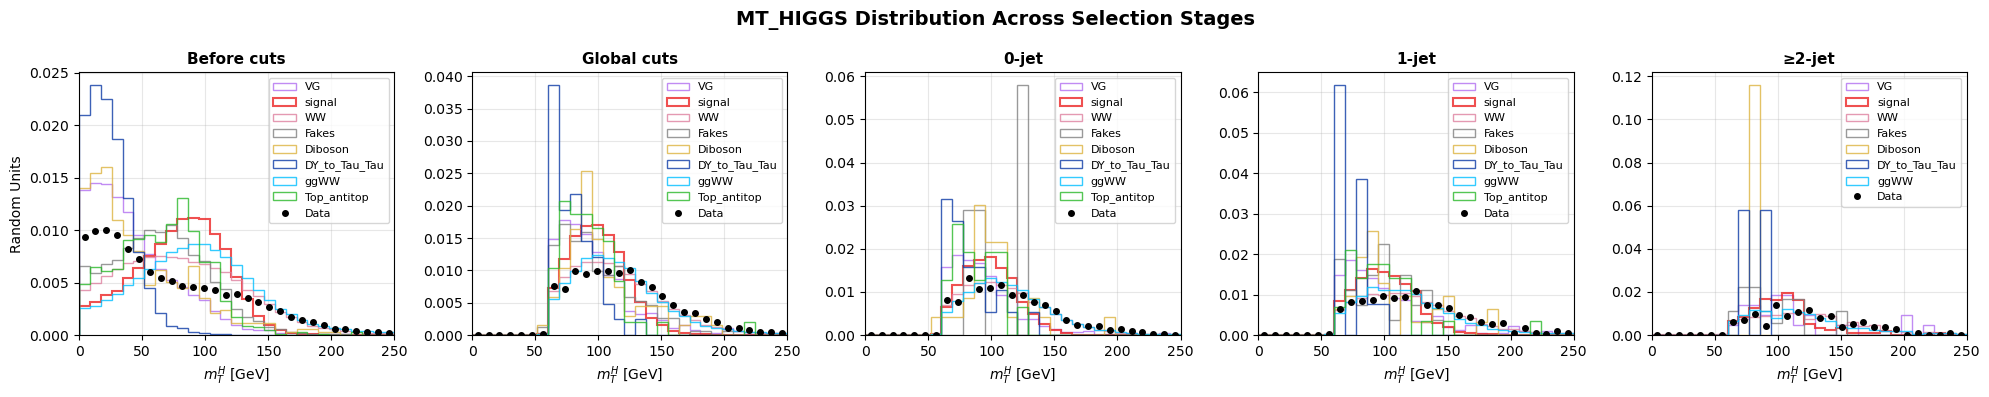


Plotting mt_l2_met...


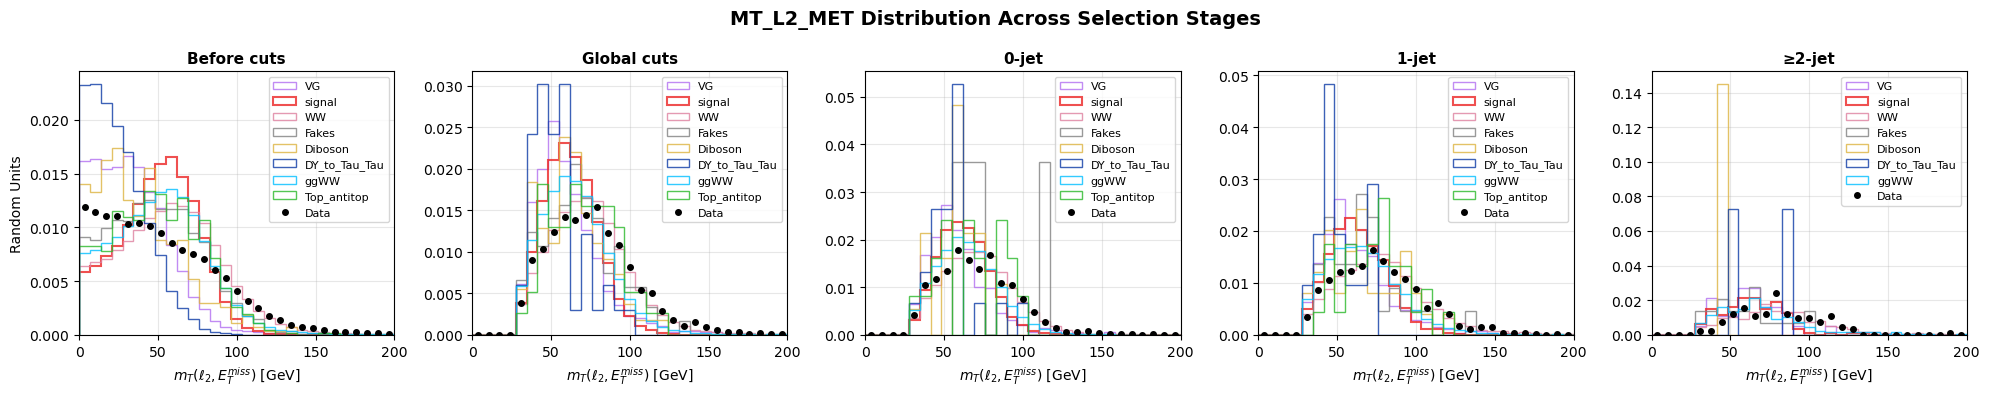


Plotting mjj...


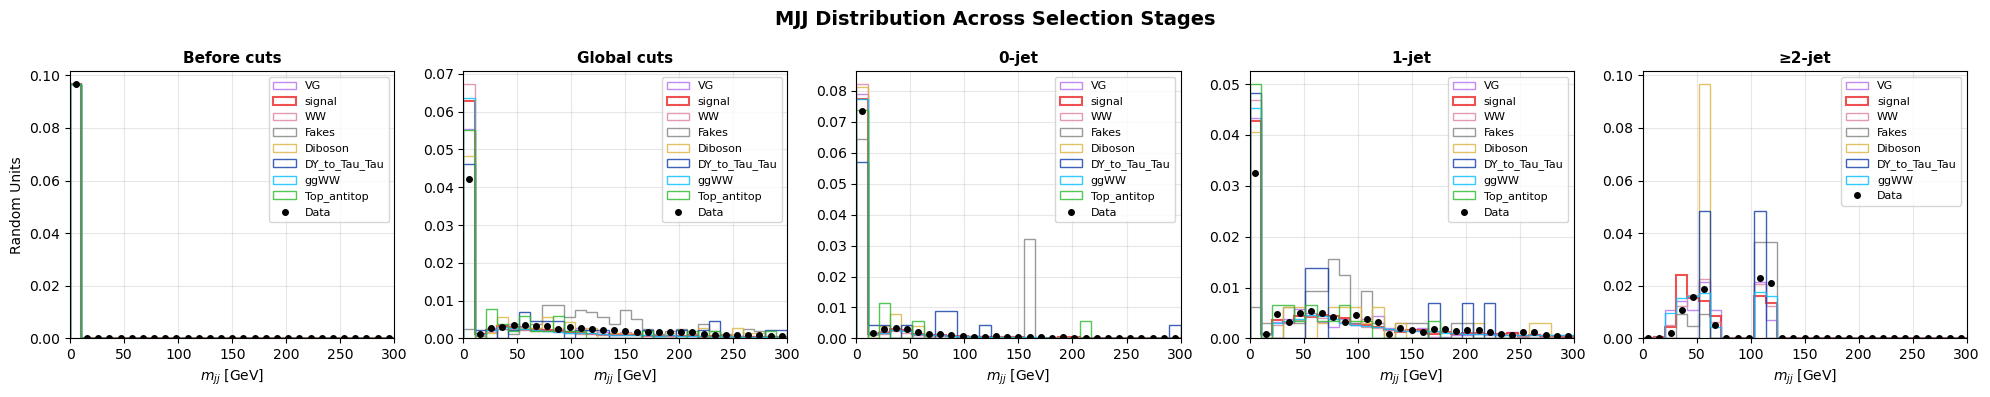

In [22]:
# Plot comparisons for key variables
print("\n" + "="*60)
print("Creating comparison plots...")
print("="*60)

# Plot all variables with signal and backgrounds superimposed
for var_name, var_props in variables_to_plot.items():
    print(f"\nPlotting {var_name}...")
    fig = plot_stage_comparison(var_name, var_props, stage_data_final)
    plt.show()

## Stacked plots

In [23]:
def get_backgrounds_and_signal():
    """Get ordered backgrounds and signal for plotting"""
    backgrounds = [key for key, props in SAMPLES.items() 
                  if not props["is_signal"] and props["stack_order"] is not None]
    backgrounds.sort(key=lambda x: SAMPLES[x]["stack_order"])
    
    signal = [key for key, props in SAMPLES.items() if props["is_signal"]]
    
    
    return backgrounds, signal[0] if signal else None


def get_data_sample():
    """Get the data sample name from SAMPLES config"""
    for sample, config in SAMPLES.items():
        if "data" in sample.lower() or "DATA" in sample:
            return sample
    return None

In [24]:
def plot_sr_cr_stacked(variable, var_props, stage_data_all):
    """Create stacked plots for SR and CR regions across jet categories"""
    
    # Define regions and categories
    sr_categories = ['SR_0jet', 'SR_1jet', 'SR_2jet']
    cr_top_categories = ['CR_top_0jet', 'CR_top_1jet', 'CR_top_2jet']
    cr_tau_categories = ['CR_tau_0jet', 'CR_tau_1jet', 'CR_tau_2jet']
    
    category_labels = ['0-jet', '1-jet', '2-jet']
    
    # Create subplot grid: 3 rows (SR, CR_top, CR_tau) x 3 cols (0j, 1j, 2j)
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    
    # Get backgrounds and signal
    backgrounds, signal = get_backgrounds_and_signal()
    data_sample = get_data_sample()
    
    region_groups = [
        (sr_categories, 'Signal Regions', 0),
        (cr_top_categories, 'Top Control Regions', 1),
        (cr_tau_categories, 'ττ Control Regions', 2)
    ]
    
    for categories, region_name, row_idx in region_groups:
        for col_idx, (category, jet_label) in enumerate(zip(categories, category_labels)):
            ax = axes[row_idx, col_idx]
            
            # Collect background data for stacking
            stack_data = []
            stack_labels = []
            stack_colors = []
            
            # Add backgrounds
            for bkg in backgrounds:
                if (bkg in stage_data_all and 
                    stage_data_all[bkg].get(category) and
                    variable in stage_data_all[bkg][category]):
                    
                    data = ak.to_numpy(stage_data_all[bkg][category][variable])
                    if len(data) > 0:
                        stack_data.append(data)
                        stack_labels.append(bkg)
                        stack_colors.append(SAMPLES[bkg]["color"])
            
            # Get signal data
            sig_data = None
            if (signal and signal in stage_data_all and 
                stage_data_all[signal].get(category) and
                variable in stage_data_all[signal][category]):
                sig_data = ak.to_numpy(stage_data_all[signal][category][variable])
            
            # Plot stacked backgrounds
            if stack_data:
                ax.hist(stack_data, bins=var_props['bins'], 
                       label=stack_labels if row_idx == 0 and col_idx == 0 else None,
                       color=stack_colors, stacked=True, alpha=0.8, edgecolor='none')
            
            # Plot signal overlay
            if sig_data is not None and len(sig_data) > 0:
                ax.hist(sig_data, bins=var_props['bins'], 
                       histtype='step', linewidth=2, 
                       label='Signal' if row_idx == 0 and col_idx == 0 else None,
                       color=SAMPLES[signal]["color"], linestyle='-')
            
            # Plot data as black dots
            if (data_sample and data_sample in stage_data_all and 
                stage_data_all[data_sample].get(category) and
                variable in stage_data_all[data_sample][category]):
                
                data_points = ak.to_numpy(stage_data_all[data_sample][category][variable])
                if len(data_points) > 0:
                    hist, edges = np.histogram(data_points, bins=var_props['bins'])
                    centers = 0.5 * (edges[:-1] + edges[1:])
                    mask = hist > 0
                    ax.scatter(centers[mask], hist[mask], 
                              c='black', s=15, marker='o',
                              label='Data' if row_idx == 0 and col_idx == 0 else None,
                              zorder=10)
            
            # Formatting
            ax.set_xlim(var_props['xlim'])
            ax.set_yscale('log')
            ax.set_ylim(bottom=0.1)
            
            # Labels and titles
            if row_idx == 2:  # Bottom row
                ax.set_xlabel(var_props['xlabel'], fontsize=10)
            if col_idx == 0:  # Left column
                ax.set_ylabel('Events', fontsize=10)
            
            # Subplot title
            ax.set_title(f'{region_name.split()[0]} {jet_label}', fontsize=11, fontweight='bold')
            
            # Legend only on top-left subplot
            if row_idx == 0 and col_idx == 0:
                ax.legend(fontsize=8, loc='upper right')
            
            ax.grid(True, alpha=0.3)
    
    # Overall title
    plt.suptitle(f'{variable.upper()} Distribution: Signal and Control Regions', 
                fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    
    # Add explicit plt.show() and return figure
    plt.show()
    return fig




Creating comparison plots...

Plotting mass...


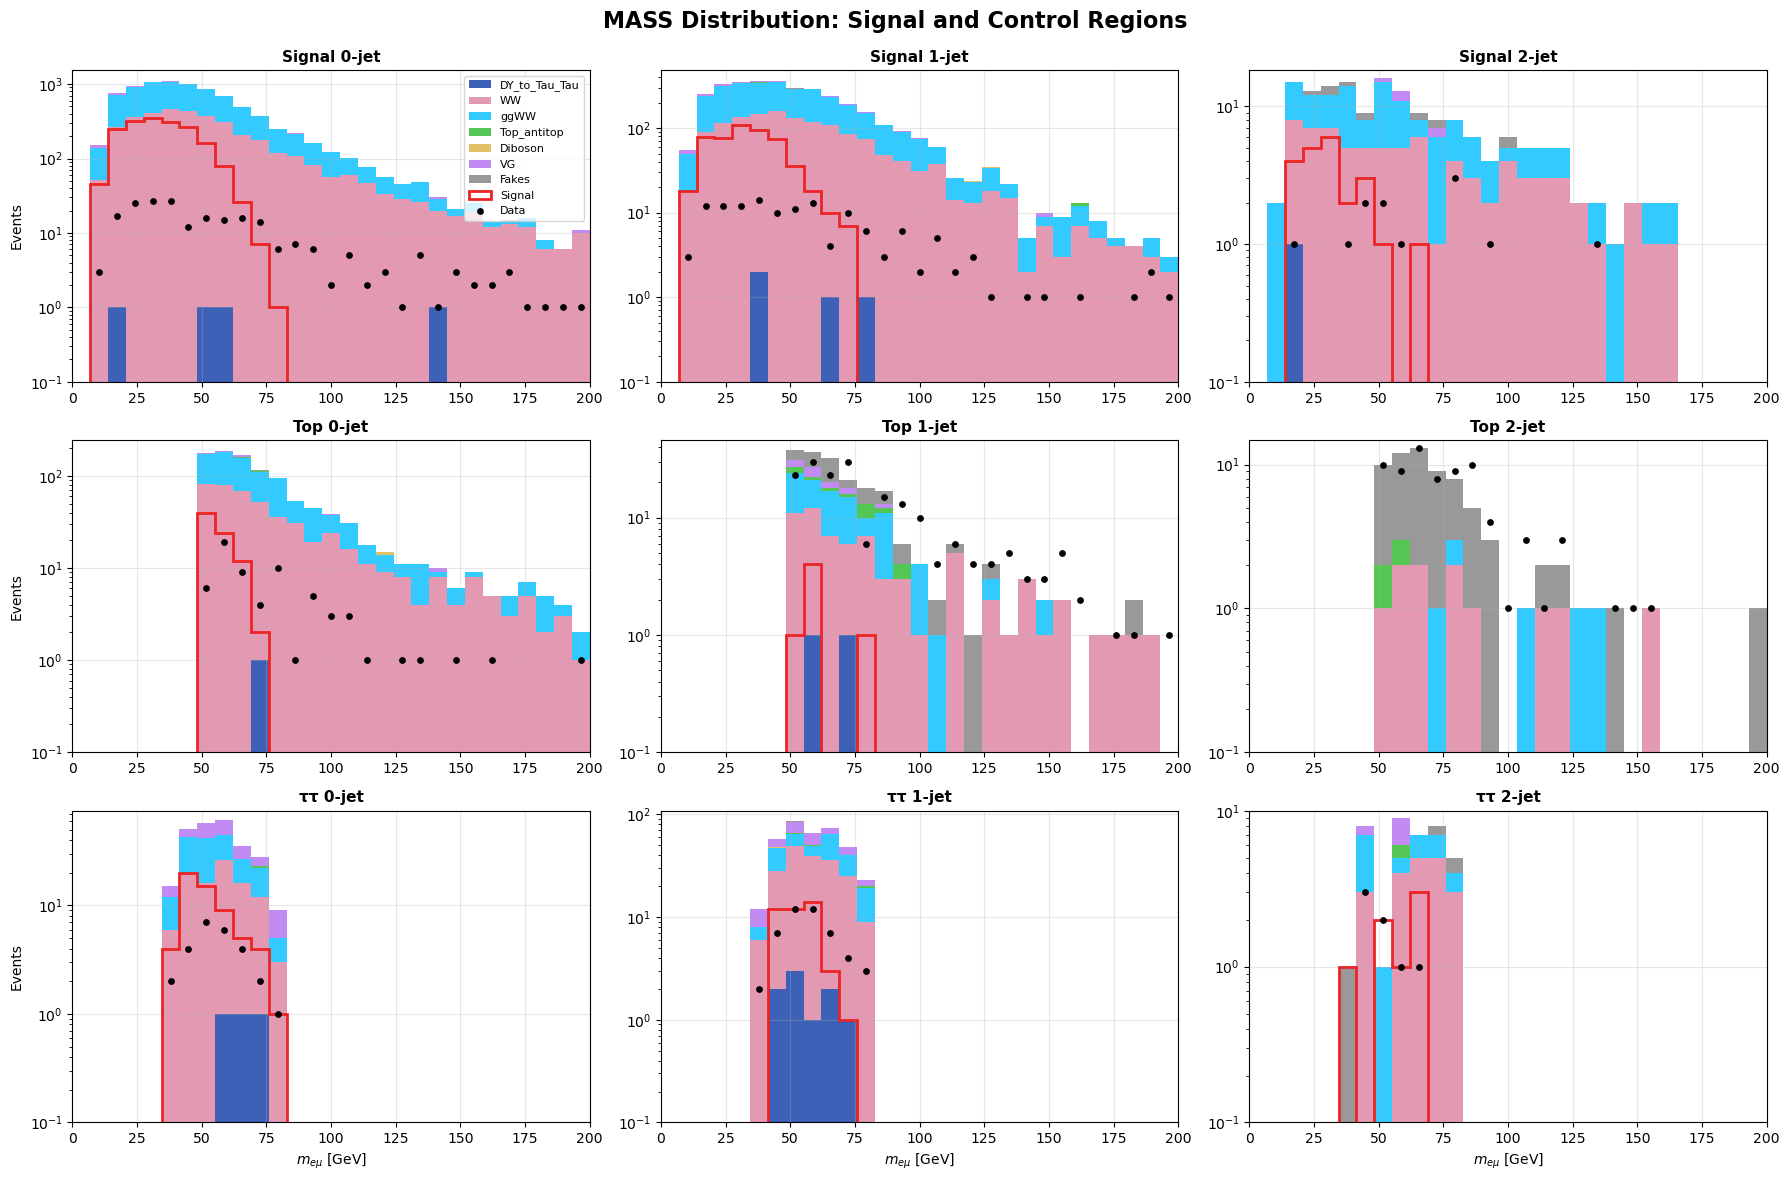


Plotting met...


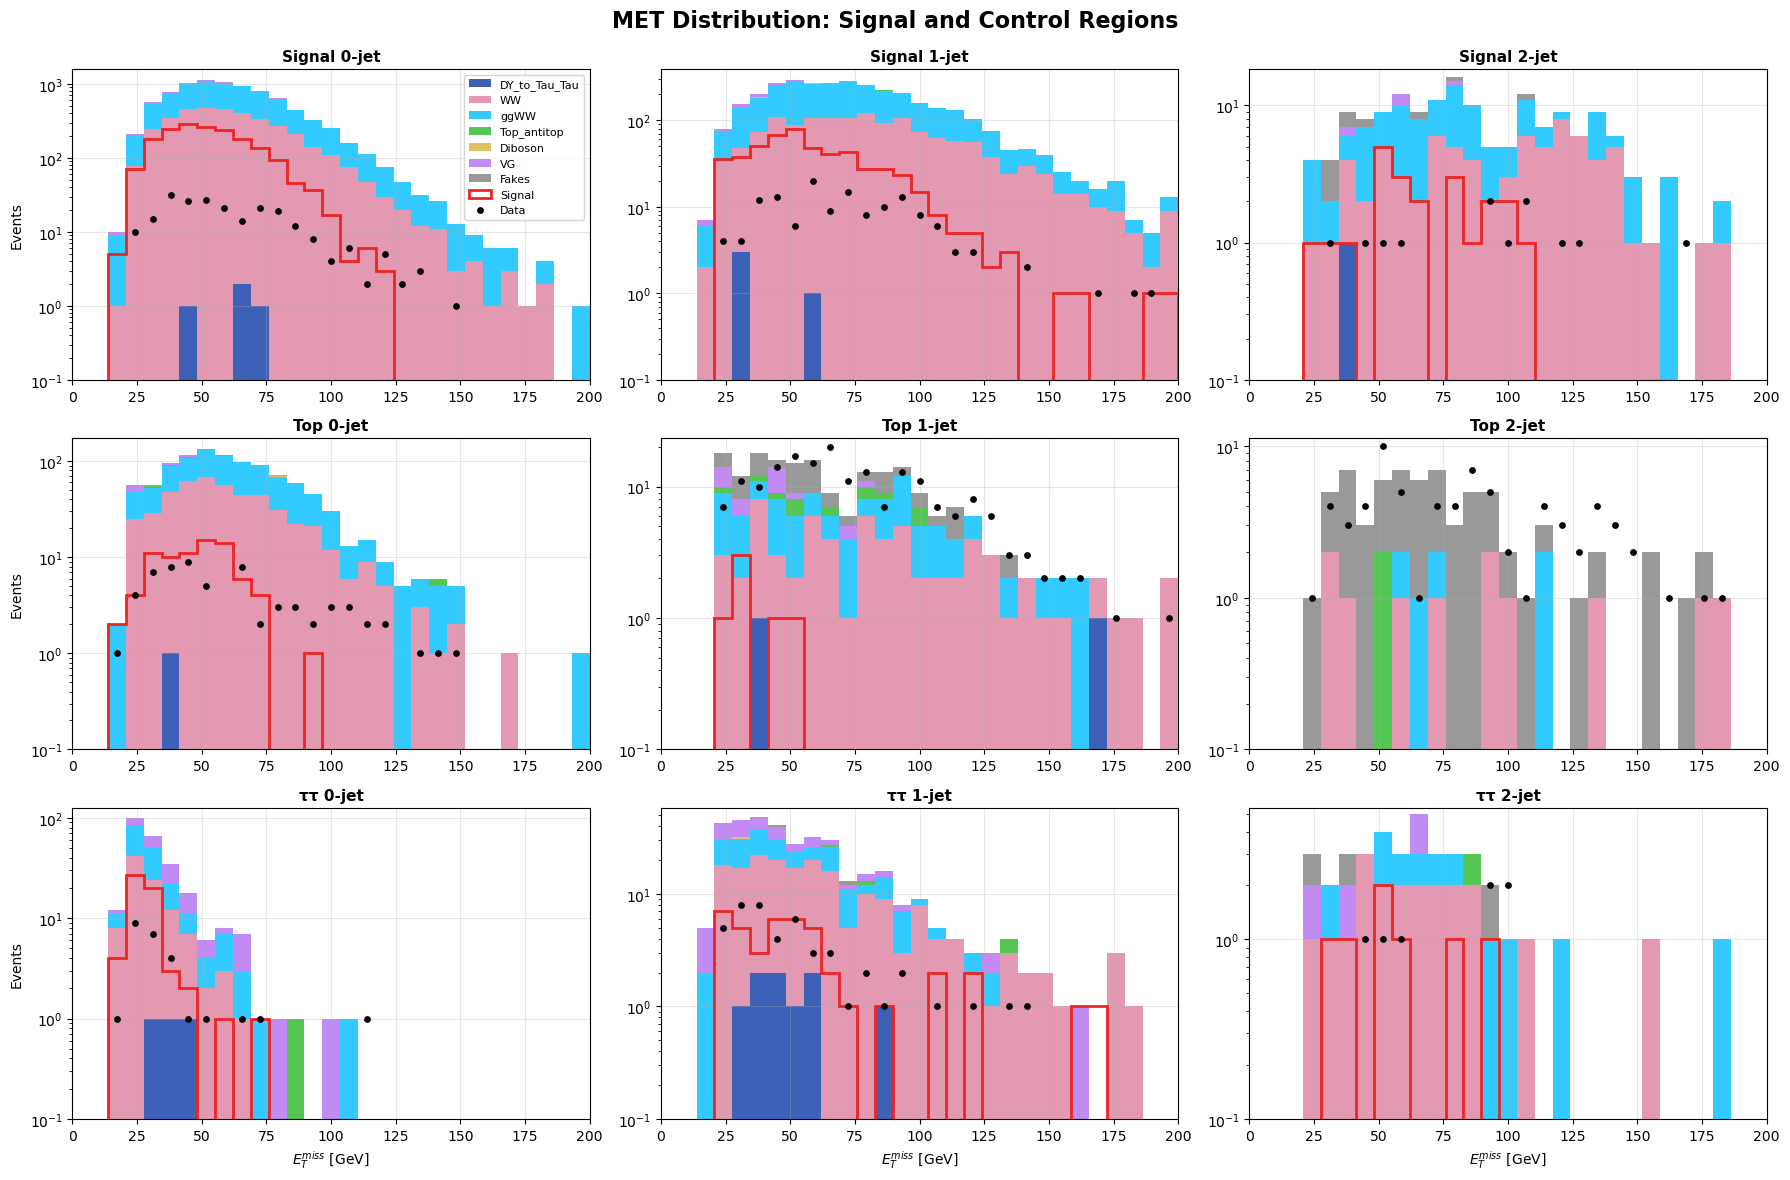


Plotting dphi...


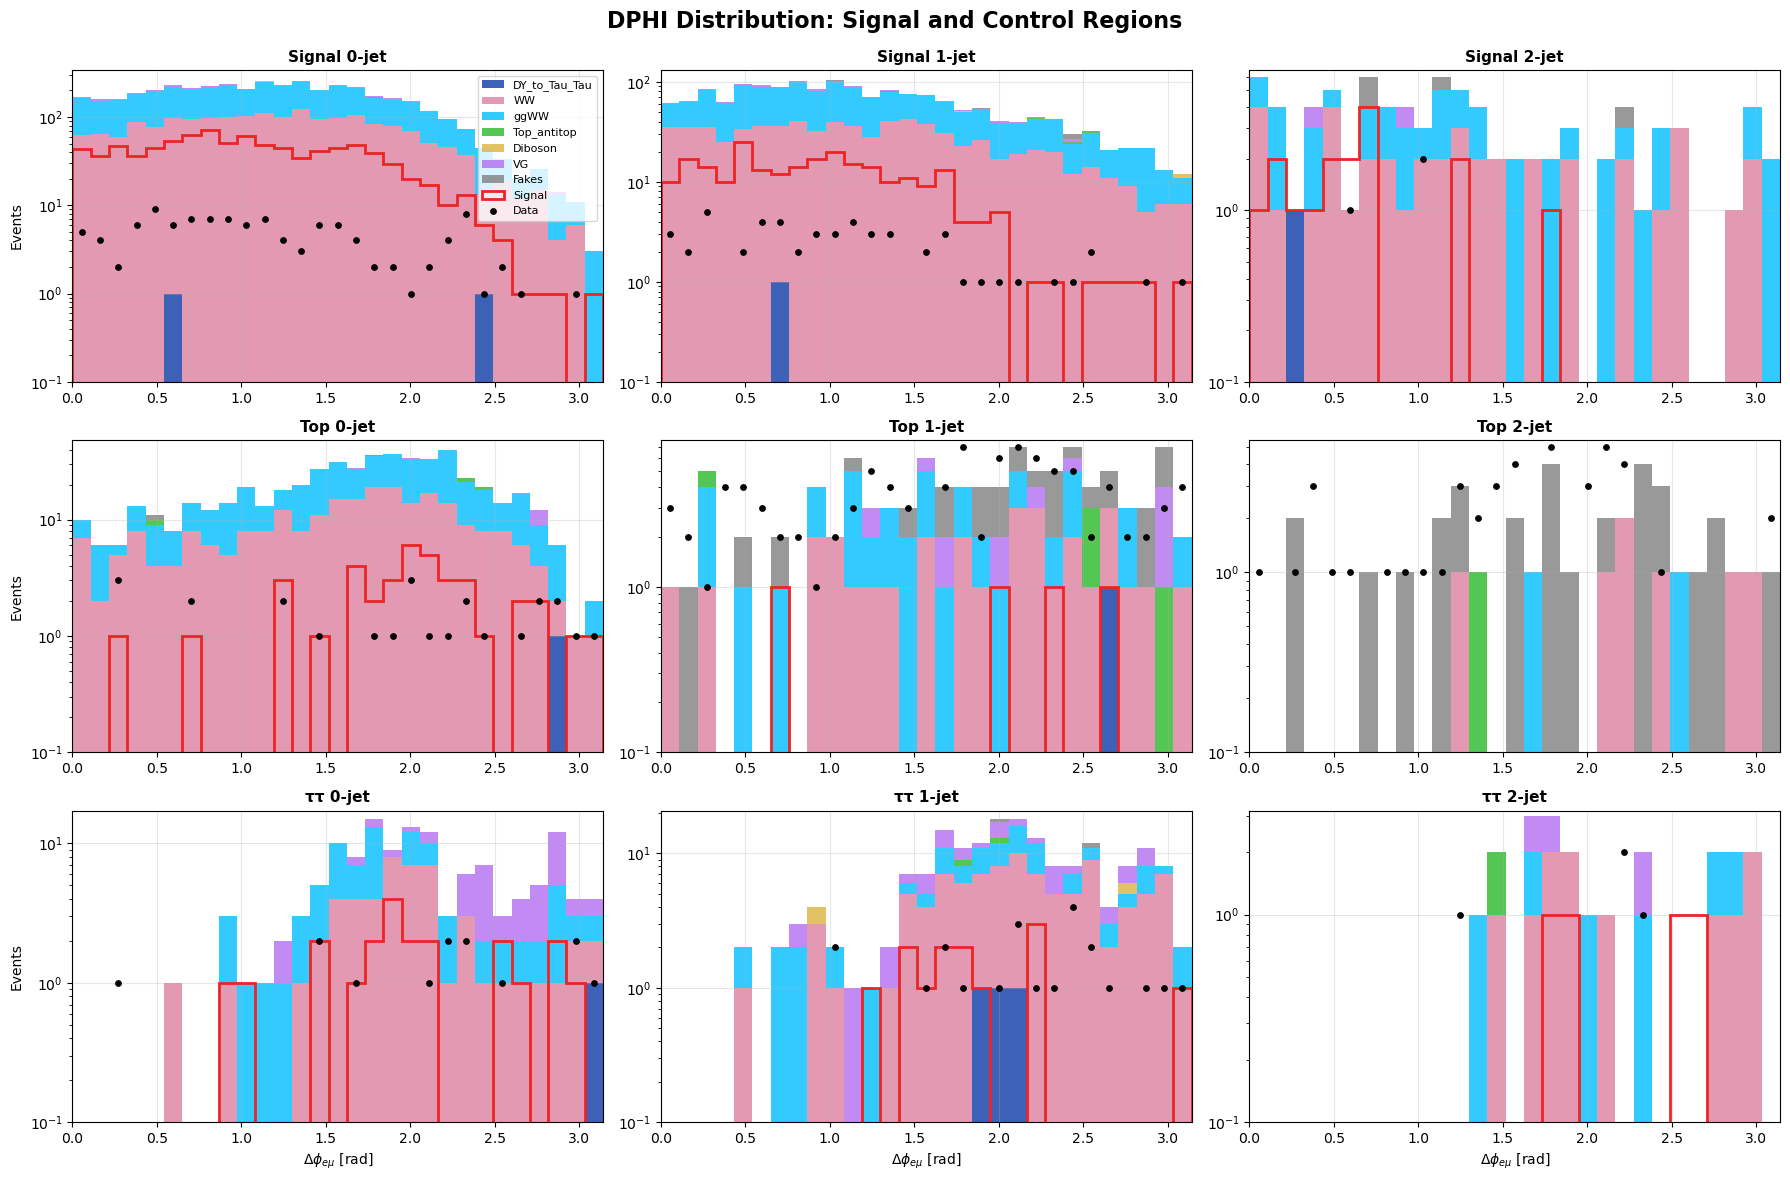


Plotting ptll...


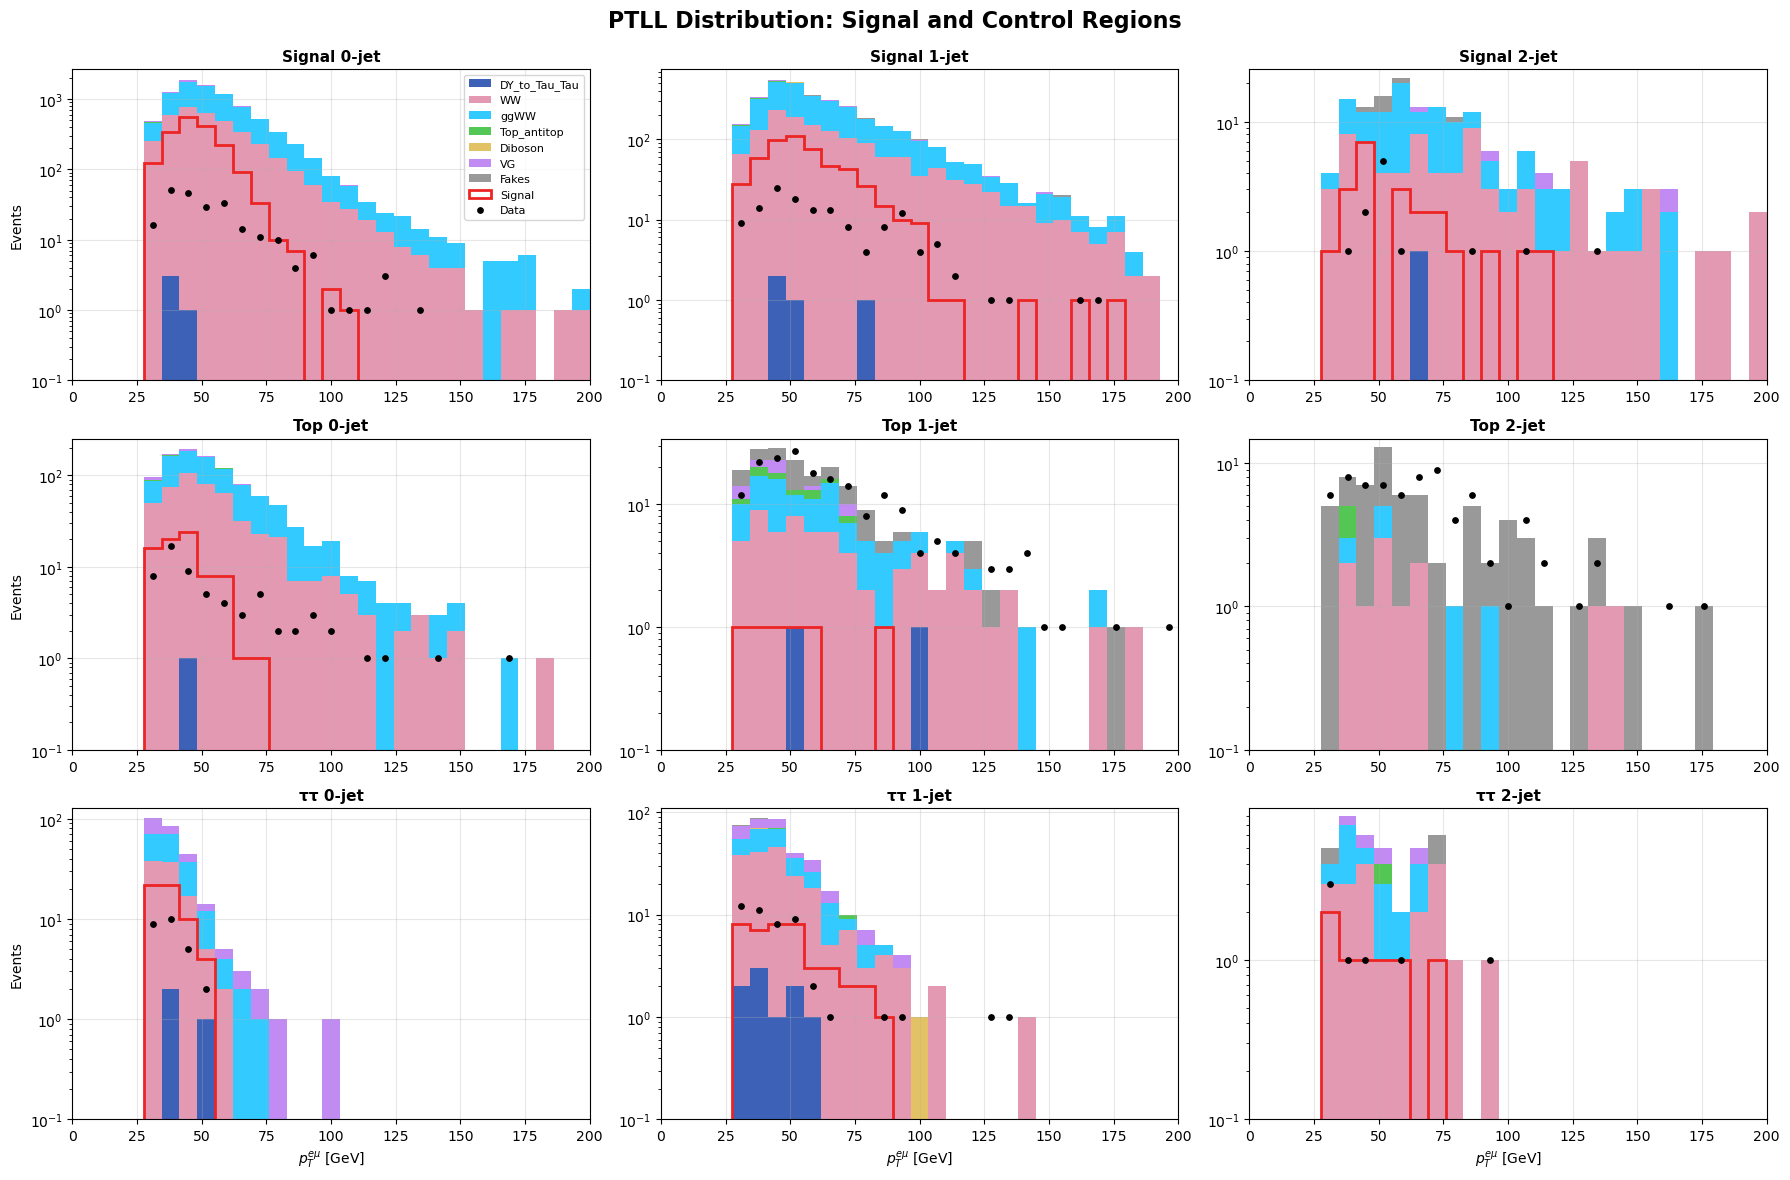


Plotting mt_higgs...


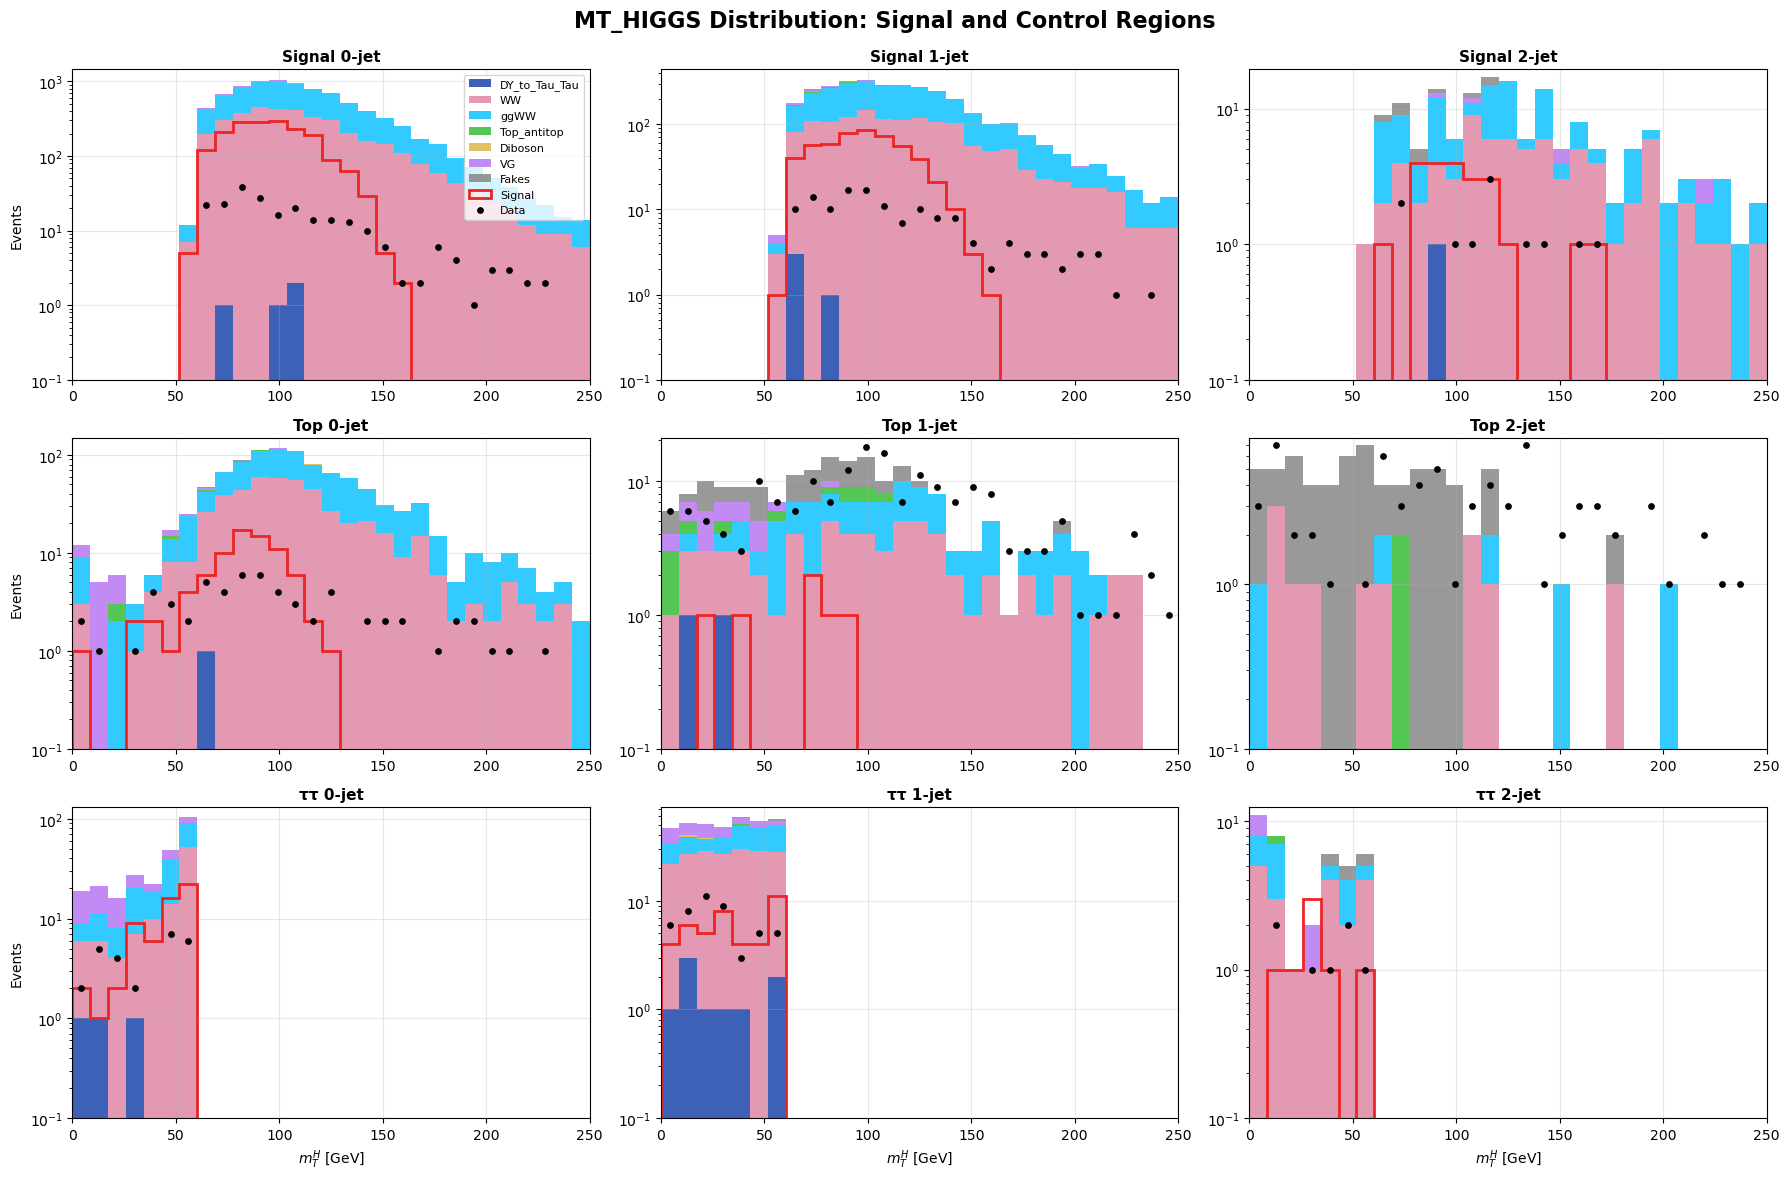


Plotting mt_l2_met...


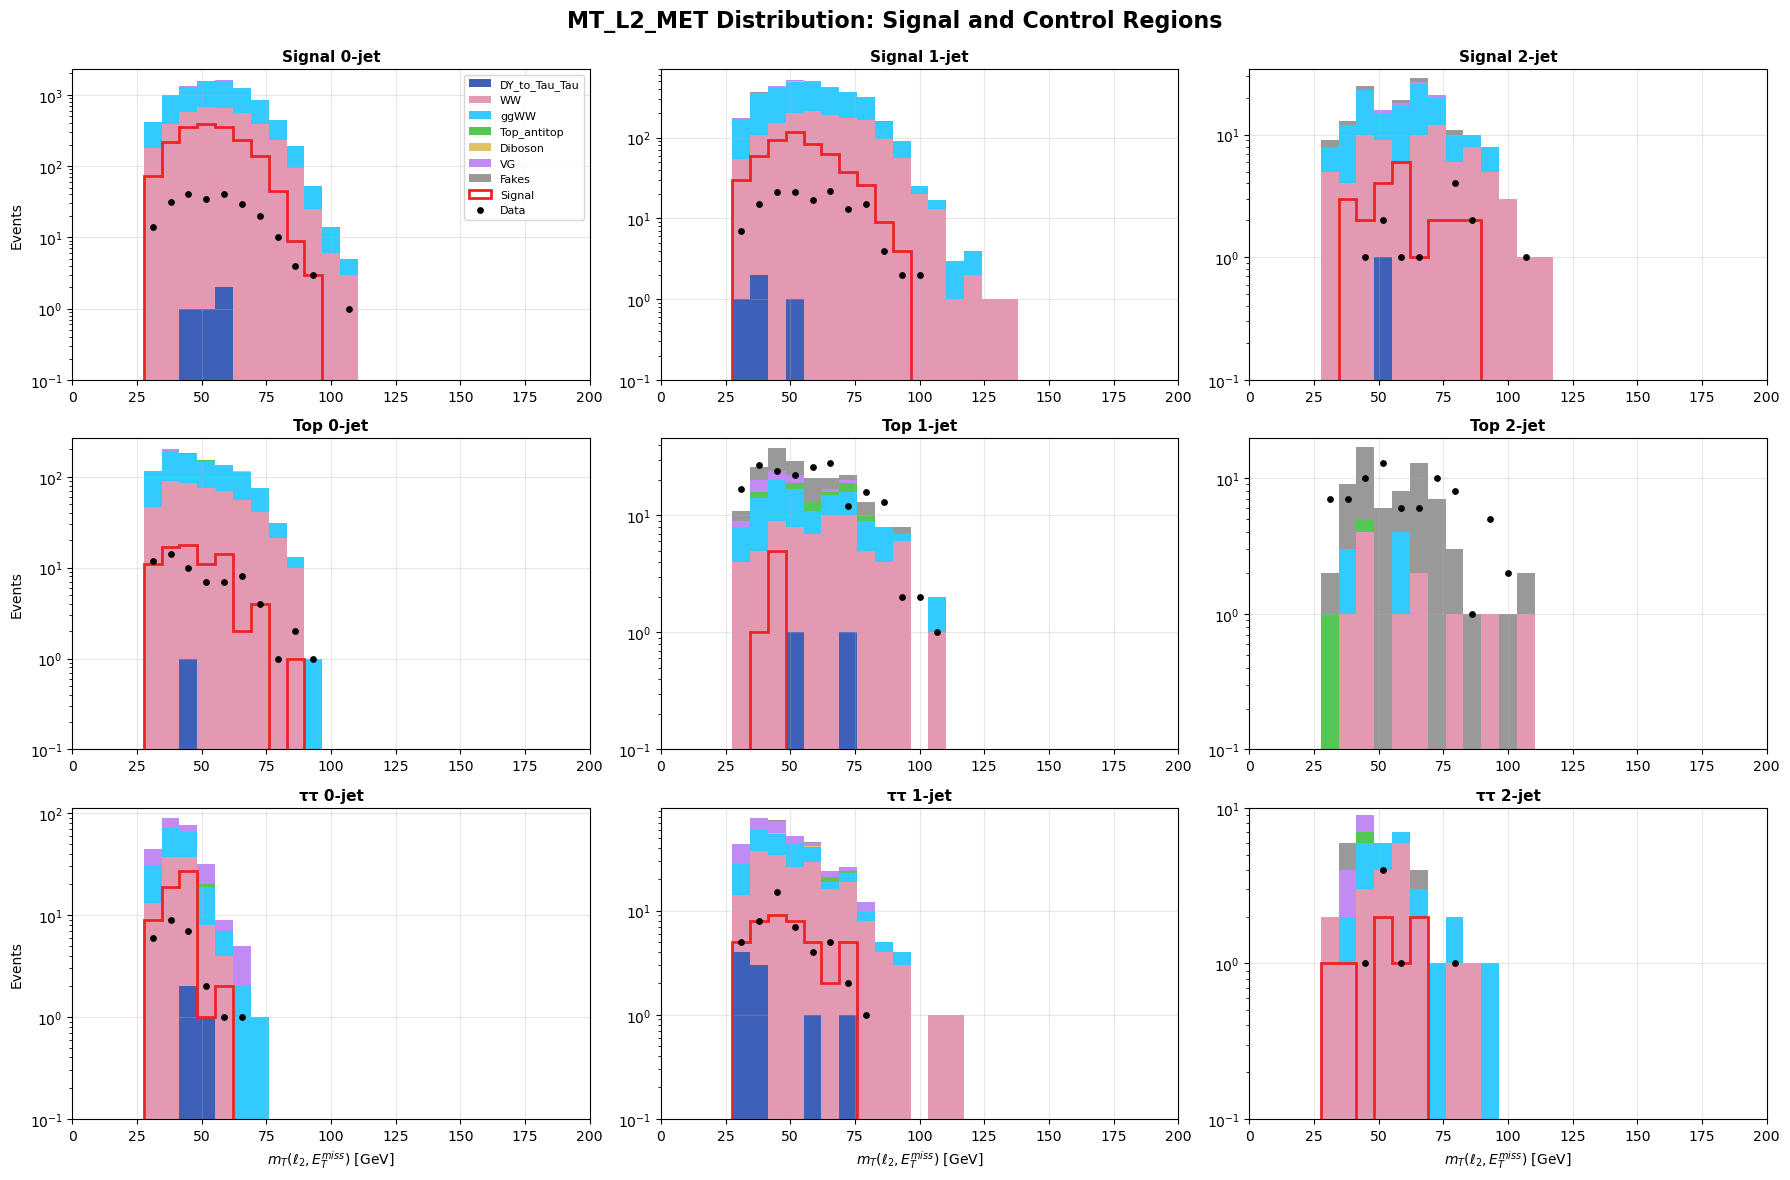


Plotting mjj...


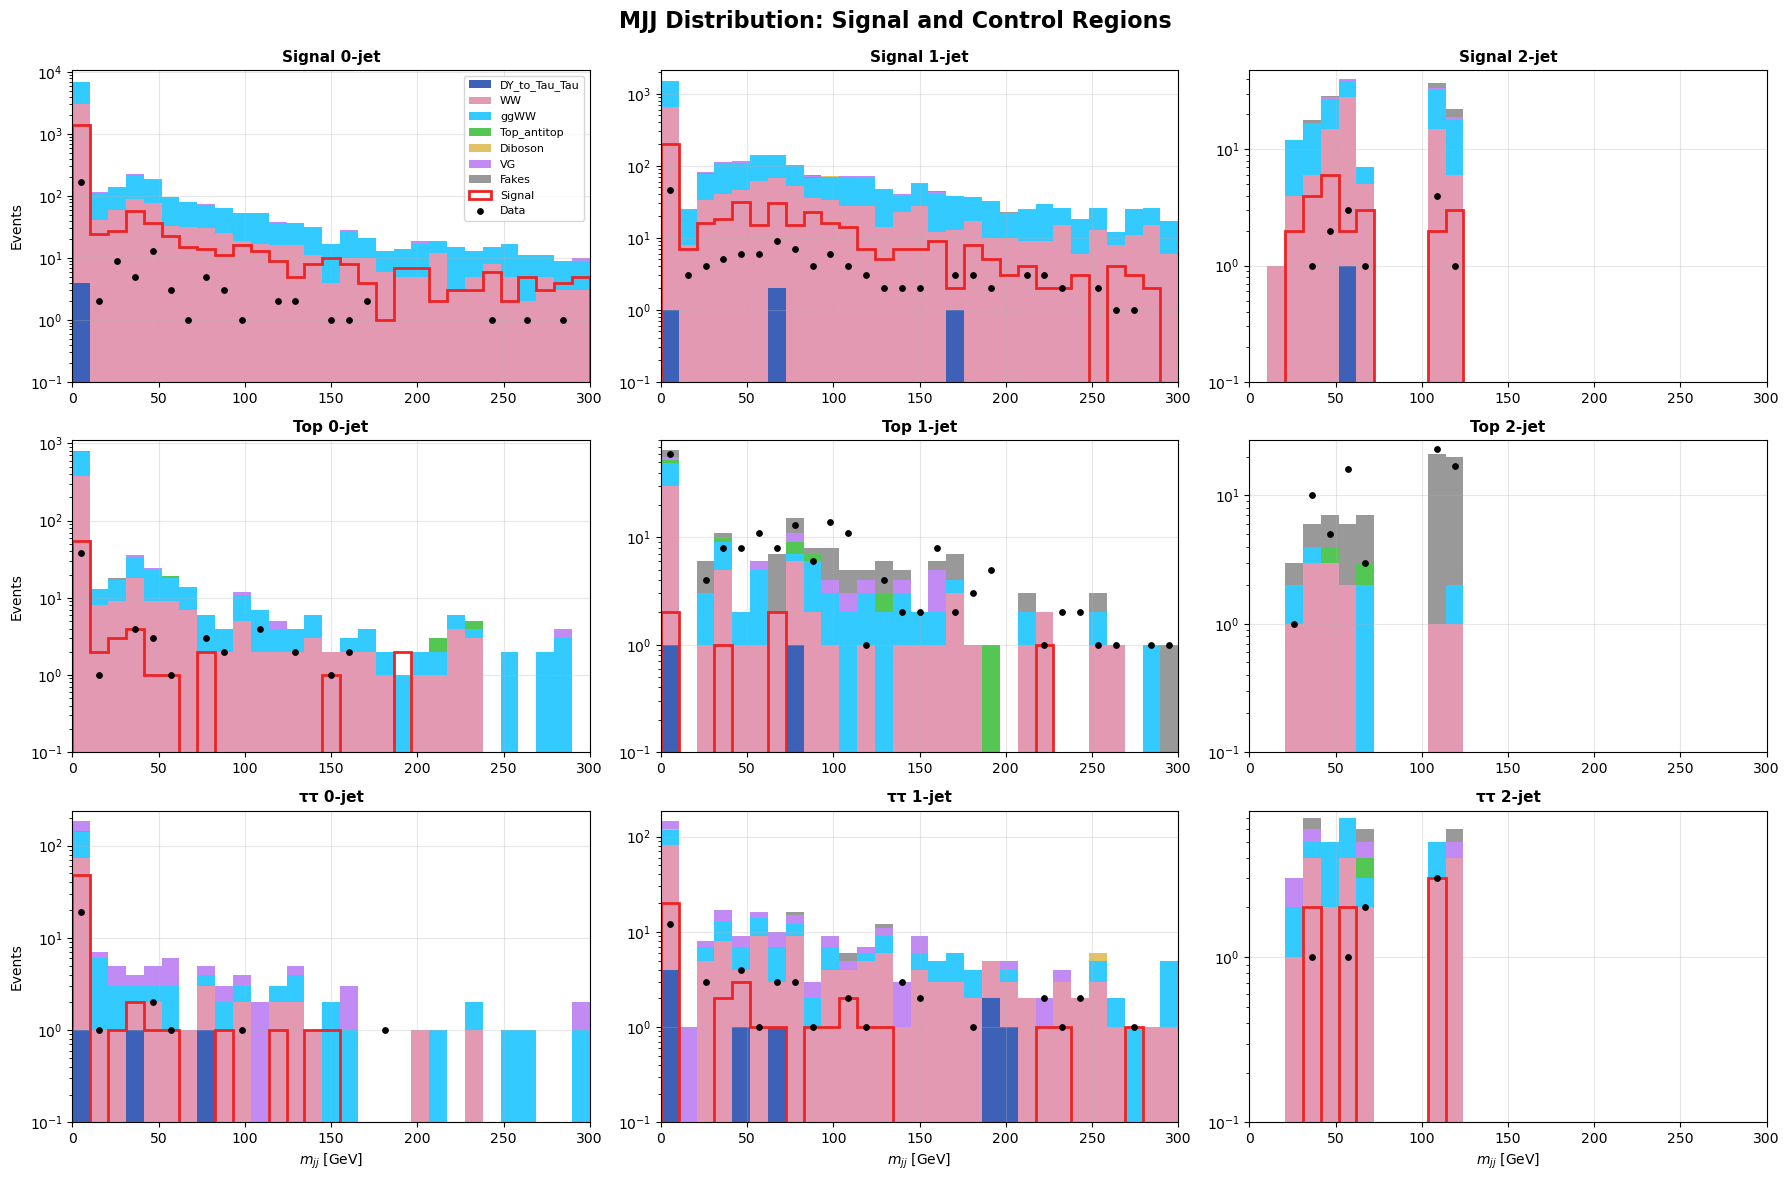

In [25]:
# Plot comparisons with both styles
print("\n" + "="*60)
print("Creating comparison plots...")
print("="*60)

for var_name, var_props in variables_to_plot.items():
    print(f"\nPlotting {var_name}...")
    
    # Step histograms (overlaid)
    # fig1 = plot_stage_comparison(var_name, var_props, stage_data_final)
    # plt.show()
    
    # Stacked backgrounds with signal overlay
    fig2 = plot_sr_cr_stacked(var_name, var_props, stage_data_final)
    plt.show()